In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir("/content/drive/MyDrive/ABIDE/") 

Mounted at /content/drive


In [ ]:
!pip install torch==1.11.0 torchvision==0.12.0 torchaudio==0.11.0
!pip install --no-index torch-scatter -f https://pytorch-geometric.com/whl/torch-1.11.0%2Bcu102.html
!pip install --no-index torch-sparse -f https://pytorch-geometric.com/whl/torch-1.11.0%2Bcu102.html
!pip install --no-index torch-cluster -f https://pytorch-geometric.com/whl/torch-1.11.0%2Bcu102.html
!pip install --no-index torch-spline-conv -f https://pytorch-geometric.com/whl/torch-1.11.0%2Bcu102.html
!pip install torch-geometric
import torch
print(torch.__version__)  
print(torch.version.cuda)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 750.6 MB 17 kB/s 
     |████████████████████████████████| 21.0 MB 1.2 MB/s 
     |████████████████████████████████| 2.9 MB 62.0 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.12.1+cu113
    Uninstalling torch-1.12.1+cu113:
      Successfully uninstalled torch-1.12.1+cu113
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.13.1+cu113
    Uninstalling torchvision-0.13.1+cu113:
      Successfully uninstalled torchvision-0.13.1+cu113
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 0.12.1+cu113
    Uninstalling torchaudio-0.12.1+cu113:
      Successfully uninstalled torchaudio-0.12.1+cu113
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
t

1.11.0+cu102
10.2


In [ ]:
# load ComBat algorithm
# !python /content/drive/MyDrive/ABIDE/neuralCombat.py 
import sys
sys.path.append('/content/drive/MyDrive/ABIDE/')

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from neuralCombat import *
# from neuralCombat.py import neuralCombat
import pandas as pd
from sklearn import svm
import joblib
import openpyxl
from openpyxl import load_workbook
import os
import scipy.io as scio
import argparse
import numpy as np
import time
import torch
import torch.utils.data
import torch.nn as nn
import torch.optim as optim
from torch.utils.data.dataset import Dataset
from torch.autograd import Variable
from torchvision import datasets, transforms
from torchvision.utils import make_grid , save_image
import torchvision.utils as vutils
from os.path import join
from os import listdir
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import DataLoader
from collections import OrderedDict
import nibabel as nib
import matplotlib.pyplot as plt
import cv2 as cv
from os import path
import shutil
import scipy.stats
import scipy.ndimage
import random
import torch.nn.init as init
import torch.nn.functional as F
import sys
import math
from functools import reduce
import operator
from scipy.interpolate import interp1d
from torch.optim import lr_scheduler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeClassifier
from sklearn.feature_selection import RFE

def feature_selection_fMRI(matrix, labels, train_ind, fnum):
    """
        matrix       : feature matrix (num_subjects x num_features)
        labels       : ground truth labels (num_subjects x 1)
        train_ind    : indices of the training samples
        fnum         : size of the feature vector after feature selection 

    return:
        x_data      : feature matrix of lower dimension (num_subjects x fnum)
    """

    estimator = RidgeClassifier()
    selector = RFE(estimator, n_features_to_select=fnum, step=100, verbose=1)

    featureX = matrix[train_ind, :]
    featureY = labels[train_ind]
    selector = selector.fit(featureX, featureY.ravel())

    return selector
def feature_selection_sMRI(matrix, labels, train_ind, fnum):
    """
        matrix       : feature matrix (num_subjects x num_features)
        labels       : ground truth labels (num_subjects x 1)
        train_ind    : indices of the training samples
        fnum         : size of the feature vector after feature selection 

    return:
        x_data      : feature matrix of lower dimension (num_subjects x fnum)
    """

    estimator = RidgeClassifier()
    selector = RFE(estimator, n_features_to_select=fnum, step=10, verbose=1)

    featureX = matrix[train_ind, :]
    featureY = labels[train_ind]
    selector = selector.fit(featureX, featureY.ravel())

    return selector

def get_index(lst=None, item=''):
	return [i for i in range(len(lst)) if lst[i] == item]

def flatten_one(length, img):
	'''
	  In some situations, the dimension on z-axis of images are smaller than
	  the dimension of z-axis of patches, this function will be used to pad
	'''

	one_line = np.zeros((1, int(length)))
	position = 0
	for i in range(img.shape[0]):  # column
		for j in range(i + 1, img.shape[1]):  # row
			one_line[0, position] = img[j, i]
			position = position + 1
	return one_line


def get_ids(num_subjects=None,dir_path=''):
	"""
	return:
		subject_IDs    : list of all subject IDs
	"""
	subject_IDs = np.genfromtxt(os.path.join(dir_path, 'subject_IDs.txt'), dtype=str)

	if num_subjects is not None:
		subject_IDs = subject_IDs[:num_subjects]

	return subject_IDs

def save_model(net,path, name_net):

  # This fucntion is used to save a specific model

    path_net =  path + '/' + name_net + '.pth'
    torch.save(net.cpu().state_dict(), path_net)
    net.cuda()

def load_model(net, path, name_net):

  # This function is used to load a specific model we saved before

    path_net =  path + '/' + name_net + '.pth'
    net.load_state_dict(torch.load(path_net))

    return net



In [ ]:
########################################### Load Data ###############################################
#####################################################################################################
#####################################################################################################
fMRI_atlas = 'CC200'  # AAL or CC200
combat_fMRI = True    # True or False
combat_sMRI = True

if combat_sMRI == False:
  save_combat_sMRI = '/without_ComBat/'
else:
  save_combat_sMRI = '/with_ComBat/'

# fMRI path
save_path = '/content/drive/MyDrive/ABIDE/save_models/CC200_sMRI/'+ save_combat_sMRI
root_path_fMRI = '/content/dataset'
if os.path.exists(root_path_fMRI):
  shutil.rmtree(root_path_fMRI) 
shutil.copytree('/content/drive/MyDrive/ABIDE/' + fMRI_atlas + '/original/', root_path_fMRI) 
label_dir = '/content/drive/MyDrive/ABIDE/phenotypic_image_quality'

# sMRI path
localDir = '/content/sMRI_dataset/'
if os.path.exists(localDir):
  shutil.rmtree(localDir) 
os.makedirs(localDir)
!unzip '/content/drive/MyDrive/ABIDE/freesurfer_stats.zip' -d '/content/sMRI_dataset'
localDir = localDir + 'freesurfer_stats/'


k_fold = 5
new_number_features_fMRI = 5000
new_number_features_sMRI = 1435
new_number_features_combine = 6000
number_samples = 871
useless_samples = ['51334']
if fMRI_atlas == 'AAL':
  image_size = [116, 116]
else:
  image_size = [200, 200]
scaler = True


age_name = 'ages.mat'
gender_name = 'genders.mat'
label_name = 'ABIDE_label_871.mat'
label = scio.loadmat(os.path.join(label_dir, label_name))
label = label['label'][0]
labels = np.zeros(number_samples - len(useless_samples))
site_name = 'sites.mat'
site = scio.loadmat(os.path.join(label_dir, site_name))
all_sites = site['sites']
for i in range(len(all_sites)):
	site = all_sites[i]
	all_sites[i] = site.replace(' ', '')
unique_sites = np.unique(all_sites)
sites = []
unique_sites = list(unique_sites)

age = scio.loadmat(os.path.join(label_dir, age_name))
age = age['ages']
ages = np.zeros((number_samples - len(useless_samples), 1))

gender = scio.loadmat(os.path.join(label_dir, gender_name))
gender = gender['genders']
genders = np.zeros((number_samples - len(useless_samples), 1))

subject_IDs = get_ids(number_samples,dir_path=label_dir)
subject_IDs = subject_IDs.tolist()
length = image_size[0] * (image_size[1]-1) / 2
fMRI_images = np.zeros((number_samples - len(useless_samples), int(length)))

EV_GCN_unique = list(unique_sites)
EV_GCN_site = np.zeros([number_samples - len(useless_samples)], dtype=np.int)
EV_GCN_age = np.zeros([number_samples - len(useless_samples)], dtype=np.float32)
EV_GCN_gender = np.zeros([number_samples - len(useless_samples)], dtype=np.int)

position = 0
print('constructing fMRI features')
for i in range(number_samples):
  subject_name = subject_IDs[i]
  if subject_name in useless_samples:
    subject_index = get_index(lst=subject_IDs, item=subject_name)
    print('The index for sample ' + subject_name + ' is : ', subject_index)
  else:
    image_name = subject_name + '.mat'
    subject_index = get_index(lst=subject_IDs, item=subject_name)
    image = scio.loadmat(os.path.join(root_path_fMRI, image_name))
    img = image['connectivity']

    idx = np.triu_indices_from(img, 1)
    fMRI_images[position, :] = img[idx]
    sites.append(all_sites[subject_index[0]])
    labels[position] = label[subject_index[0]]
    genders[position] = int(gender[subject_index[0]]) + 1
    ages[position] = float(age[subject_index[0]])
    position = position + 1

for i in range(number_samples - len(useless_samples)): 

  EV_GCN_site[i] = EV_GCN_unique.index(sites[i])
  EV_GCN_age[i] = ages[i]
  EV_GCN_gender[i] = genders[i]

phonetic_data = np.zeros([number_samples - len(useless_samples), 3], dtype=np.float32)
phonetic_data[:,0] = EV_GCN_site 
phonetic_data[:,1] = EV_GCN_gender 
phonetic_data[:,2] = EV_GCN_age

pd_dict = {}
pd_dict['SITE_ID'] = np.copy(phonetic_data[:,0])
pd_dict['SEX'] = np.copy(phonetic_data[:,1])
pd_dict['AGE_AT_SCAN'] = np.copy(phonetic_data[:,2]) 


if scaler == True:
	fMRI_images = StandardScaler().fit_transform(fMRI_images)

流式输出内容被截断，只能显示最后 5000 行内容。
   creating: /content/sMRI_dataset/freesurfer_stats/51095/
  inflating: /content/sMRI_dataset/freesurfer_stats/51095/aseg.stats  
  inflating: /content/sMRI_dataset/freesurfer_stats/51095/brainvol.stats  
  inflating: /content/sMRI_dataset/freesurfer_stats/51095/lh.aparc.a2009s.stats  
  inflating: /content/sMRI_dataset/freesurfer_stats/51095/lh.aparc.DKTatlas.stats  
  inflating: /content/sMRI_dataset/freesurfer_stats/51095/lh.aparc.pial.stats  
  inflating: /content/sMRI_dataset/freesurfer_stats/51095/lh.aparc.stats  
  inflating: /content/sMRI_dataset/freesurfer_stats/51095/lh.BA_exvivo.stats  
  inflating: /content/sMRI_dataset/freesurfer_stats/51095/lh.BA_exvivo.thresh.stats  
  inflating: /content/sMRI_dataset/freesurfer_stats/51095/lh.curv.stats  
  inflating: /content/sMRI_dataset/freesurfer_stats/51095/lh.w-g.pct.stats  
  inflating: /content/sMRI_dataset/freesurfer_stats/51095/rh.aparc.a2009s.stats  
  inflating: /content/sMRI_dataset/freesurfer_sta

<ipython-input-5-0ac15da6fdfb>:73: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EV_GCN_site = np.zeros([number_samples - len(useless_samples)], dtype=np.int)
<ipython-input-5-0ac15da6fdfb>:75: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional i

constructing fMRI features
The index for sample 51334 is :  [799]


In [ ]:
############################################### Load sMRI ###############################################################
############################################### Load sMRI ###############################################################
############################################### Load sMRI ###############################################################
############################################### Load Desikan_Killiany_features
left = 'lh.aparc.stats'
right = 'rh.aparc.stats'
number_roi = 68
feature_list = ['NumVert', 'SurfArea', 'GrayVol', 'ThickAvg', 'ThickStd', 'MeanCurv', 'GausCurv', 'FoldInd', 'CurvInd']
names = ['StructName', 'NumVert', 'SurfArea', 'GrayVol', 'ThickAvg', 'ThickStd', 'MeanCurv', 'GausCurv', 'FoldInd', 'CurvInd']
skiprows= list(range(0,61))
Desikan_Killiany_features = np.zeros((number_samples - len(useless_samples), number_roi * len(feature_list)))


position = 0
print('constructing Desikan-Killiany Atlas features')
for i in range(number_samples):
  subject_name = subject_IDs[i]
  if subject_name in useless_samples:
    subject_index = get_index(lst=subject_IDs, item=subject_name)
    print('The index for sample ' + subject_name + ' is : ', subject_index)
  else:
    table_left = pd.read_table(localDir + subject_name + '/' + left, sep='\s+', names=names,
						  skiprows=skiprows)
    table_right = pd.read_table(localDir + subject_name + '/' + right, sep='\s+', names=names,
						  skiprows=skiprows)

    for j in range(len(feature_list)):
      feature_name = feature_list[j]
      left_features = table_left[feature_name].values.tolist()
      right_features = table_right[feature_name].values.tolist()
      all_features = left_features + right_features
      if len(all_features) != number_roi:
       print('The sample ' + subject_name + ' has mistake!')
      all_features = np.array(all_features)
      Desikan_Killiany_features[position, j*number_roi : (j+1)*number_roi] = all_features
    position = position + 1

if scaler == True:
	for i in range(len(feature_list)):
		Desikan_Killiany_features[:, i * number_roi: (i+1) * number_roi] = StandardScaler().fit_transform(Desikan_Killiany_features[:, i * number_roi: (i+1) * number_roi])

print('finished')

############################################### Load aseg features
print('constructing aseg features')
number_roi_aseg = 45
aseg = 'aseg.stats'
feature_list_aseg = ['Number of Voxels', 'Volume', 'Intensity normMean', 'Itensity normStdDev', 'Intensity normMin', 'Intensity normMax', 'Intensity normRange']
names_aseg = ['ColHeader Index', 'Segmentation Id ', 'Number of Voxels', 'Volume', 'Structure Name', 'Intensity normMean', 'Itensity normStdDev', 'Intensity normMin', 'Intensity normMax', 'Intensity normRange']
skiprows_aseg= list(range(0,79))
aseg_features = np.zeros((number_samples - len(useless_samples), number_roi_aseg * len(feature_list_aseg)))

position = 0
for i in range(number_samples):
	subject_name = subject_IDs[i]
	if subject_name in useless_samples:
		subject_index = get_index(lst=subject_IDs, item=subject_name)
		print('The index for sample ' + subject_name + ' is : ', subject_index)
	else:
		table_left = pd.read_table(localDir + subject_name + '/' + aseg, sep='\s+', names=names_aseg,
						  skiprows=skiprows_aseg)
		for j in range(len(feature_list_aseg)):
			feature_name = feature_list_aseg[j]
			left_features = table_left[feature_name].values.tolist()
			if len(left_features) != number_roi_aseg:
				print('The sample ' + subject_name + ' has mistake!')
			all_features = np.array(left_features)
			aseg_features[position, j*number_roi_aseg : (j+1)*number_roi_aseg] = all_features
		position = position + 1

if scaler == True:
	for i in range(len(feature_list_aseg)):
		aseg_features[:, i * number_roi_aseg: (i+1) * number_roi_aseg] = StandardScaler().fit_transform(aseg_features[:, i * number_roi_aseg: (i+1) * number_roi_aseg])
print('finished')

############################################### Load wmparc features
number_roi_wmparc = 70
wmparc = 'wmparc.stats'
feature_list_wmparc = ['Number of Voxels', 'Volume', 'Intensity normMean', 'Itensity normStdDev', 'Intensity normMin', 'Intensity normMax', 'Intensity normRange']
names_wmparc = ['ColHeader Index', 'Segmentation Id ', 'Number of Voxels', 'Volume', 'Structure Name', 'Intensity normMean', 'Itensity normStdDev', 'Intensity normMin', 'Intensity normMax', 'Intensity normRange']
skiprows_wmparc= list(range(0,65))
wmparc_features = np.zeros((number_samples - len(useless_samples), number_roi_wmparc * len(feature_list_wmparc)))

print('constructing wmparc features')
position = 0
for i in range(number_samples):
	subject_name = subject_IDs[i]
	if subject_name in useless_samples:
		subject_index = get_index(lst=subject_IDs, item=subject_name)
		print('The index for sample ' + subject_name + ' is : ', subject_index)
	else:
		table_left = pd.read_table(localDir + subject_name + '/' + wmparc, sep='\s+', names = names_wmparc,
						  skiprows=skiprows_wmparc)
		for j in range(len(feature_list_wmparc)):
			feature_name = feature_list_wmparc[j]
			left_features = table_left[feature_name].values.tolist()
			if len(left_features) != number_roi_wmparc:
				print('The sample ' + subject_name + ' has mistake!')
			all_features = np.array(left_features)
			wmparc_features[position, j*number_roi_wmparc : (j+1)*number_roi_wmparc] = all_features
		position = position + 1
if scaler == True:
	for i in range(len(feature_list_wmparc)):
		wmparc_features[:, i * number_roi_wmparc: (i+1) * number_roi_wmparc] = StandardScaler().fit_transform(wmparc_features[:, i * number_roi_wmparc: (i+1) * number_roi_wmparc])
print('finished')

############################################### concatenation
sMRI_features = np.concatenate((Desikan_Killiany_features, aseg_features, wmparc_features),axis = 1)

constructing Desikan-Killiany Atlas features
The index for sample 51334 is :  [799]
finished
constructing aseg features
The index for sample 51334 is :  [799]
finished
constructing wmparc features
The index for sample 51334 is :  [799]
finished


(870, 1417)
(870, 19900)
[[-0.26379633 -0.36585841  0.05890851 ... -1.11697067 -0.75921467
  -1.26821845]
 [ 0.06295102 -0.10354483  0.33562979 ... -1.05248729 -0.25577202
  -0.43539667]
 [ 0.42528471  0.95491346 -0.04689668 ... -0.60110366 -0.12991135
  -0.22719123]
 ...
 [-0.3026178  -0.9917294  -0.14781855 ... -0.98800391  0.24767064
   1.36905051]
 [-1.29903544 -0.89508755 -1.63560233 ...  0.68856387  1.69506827
   0.67503236]
 [ 0.02412955  0.81225169 -0.29594582 ...  0.68856387 -0.19284168
   0.46682692]]
[[ 1.88061923  1.93466056  0.63599984 ...  1.46885436  1.98724053
   1.1636311 ]
 [ 0.66500812 -0.06661812 -0.205227   ... -0.2077196   1.01585943
  -0.42020151]
 [ 0.10988633  1.25041509  0.03347263 ...  0.58907048  0.07775594
  -0.27915372]
 ...
 [-1.36387375 -0.51655671 -0.33001366 ... -0.03915398 -0.87802826
  -1.38083403]
 [-1.53608071 -1.77684322 -0.2103792  ...  0.22321413 -0.14141626
  -0.94863806]
 [-0.10758455  0.20114007  1.34416595 ... -0.14711034  1.47870214
  -0.14

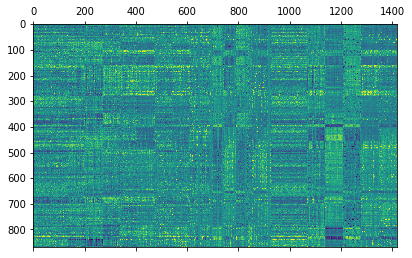

In [ ]:
print(sMRI_features.shape)
print(fMRI_images.shape)
print(sMRI_features)
print(fMRI_images)
plt.matshow(sMRI_features, vmin=-4, vmax=4)
plt.show()


In [ ]:
############################################### Combat ###############################################################
############################################### Combat ###############################################################
############################################### Combat ###############################################################

batch = []
for i in range(len(sites)):
	batch.append(get_index(lst=unique_sites, item=sites[i])[0]+1)

combat_labels = []
combat_genders = []
combat_ages = []
for i in range(len(labels)):
	combat_labels.append(labels[i] + 1)
	combat_genders.append(genders[i])
	combat_ages.append(ages[i])
 
if combat_fMRI == True:
	print('The ComBat for fMRI')
	new_all_samples_feature = fMRI_images.T
	covars = {}
	covars['batch'] = batch
	covars['labels'] = combat_labels
	covars['genders'] = combat_genders
	covars['ages'] = combat_ages
	covars = pd.DataFrame(covars)

	# To specify names of the variables that are categorical:
	categorical_cols = ['labels', 'genders']
	# To specify the name of the variable that encodes for the scanner/batch covariate:
	batch_col = 'batch'
	continuous_cols = ['ages']
	# Harmonization step:
	new_all_samples_feature = neuroCombat(dat=new_all_samples_feature,
											covars=covars,
											batch_col=batch_col,
											categorical_cols=categorical_cols,
											continuous_cols=continuous_cols)["data"]
	fMRI_images = new_all_samples_feature.T

if combat_sMRI == True:
	print('The ComBat for sMRI')
	new_all_samples_feature = sMRI_features.T
	covars = {}
	covars['batch'] = batch
	covars['labels'] = combat_labels
	covars['genders'] = combat_genders
	covars['ages'] = combat_ages
	covars = pd.DataFrame(covars)

	# To specify names of the variables that are categorical:
	categorical_cols = ['labels', 'genders']
	# To specify the name of the variable that encodes for the scanner/batch covariate:
	batch_col = 'batch'
	continuous_cols = ['ages']
	# Harmonization step:
	new_all_samples_feature = neuroCombat(dat=new_all_samples_feature,
											covars=covars,
											batch_col=batch_col,
											categorical_cols=categorical_cols,
											continuous_cols=continuous_cols)["data"]
	sMRI_features = new_all_samples_feature.T



The ComBat for fMRI
[neuroCombat] Creating design matrix
[neuroCombat] Standardizing data across features
[neuroCombat] Fitting L/S model and finding priors
[neuroCombat] Finding parametric adjustments
[neuroCombat] Final adjustment of data
The ComBat for sMRI
[neuroCombat] Creating design matrix
[neuroCombat] Standardizing data across features
[neuroCombat] Fitting L/S model and finding priors
[neuroCombat] Finding parametric adjustments
[neuroCombat] Final adjustment of data


/content/drive/MyDrive/ABIDE/neuralCombat.py:325: RuntimeWarning: divide by zero encountered in true_divide
  change = max((abs(g_new - g_old) / g_old).max(), (abs(d_new - d_old) / d_old).max())


(870, 1417)
(870, 19900)
[[-0.39239928 -0.55216102  0.1374198  ... -0.37205478 -0.07062745
  -0.64134877]
 [-0.07774417 -0.29267612  0.37513052 ... -0.27523294  0.60302642
   0.33544345]
 [ 0.2476013   0.74743091 -0.03192999 ...  0.36514416  0.7587449
   0.58261208]
 ...
 [-0.70463588 -1.49906787 -0.13151063 ... -0.58585031 -0.45536805
   0.95004168]
 [-1.33177367 -0.97515466 -1.30232848 ...  0.19861977  1.48030952
   0.27982554]
 [-0.13026378  0.6961938  -0.02895118 ...  0.21603334 -0.47497158
   0.04782907]]
[[ 1.31969574  1.29609272  0.16548012 ...  1.1264416   1.40539022
   0.89244625]
 [ 0.1978668  -0.56846397 -0.64249501 ... -0.49195432  0.53999082
  -0.51186112]
 [-0.31230063  0.64071419 -0.4209943  ...  0.28124017 -0.31134127
  -0.38226791]
 ...
 [-1.66106482 -0.70338647 -0.75717584 ...  0.07807565 -0.91287903
  -1.53599873]
 [-1.66776798 -1.80027394 -0.20547798 ...  0.20826832 -0.11814347
  -1.202585  ]
 [-0.21670001  0.0388709   1.28034576 ... -0.15455976  1.52893364
  -0.330

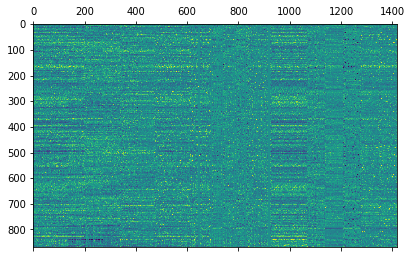

In [ ]:
print(sMRI_features.shape)
print(fMRI_images.shape)
print(sMRI_features)
print(fMRI_images)
plt.matshow(sMRI_features, vmin=-4, vmax=4)
plt.show()

In [ ]:
############################################### phenotypic ###############################################################
############################################### phenotypic ###############################################################
############################################### phenotypic ###############################################################
ages_name = 'ages.mat'
ages = scio.loadmat(os.path.join(label_dir, ages_name))
ages = ages['ages']

gender_name = 'genders.mat'
genders = scio.loadmat(os.path.join(label_dir, gender_name))
genders = genders['genders']

FIQ_name = 'FIQS.mat'
FIQS = scio.loadmat(os.path.join(label_dir, FIQ_name))
FIQS = FIQS['FIQS']

NUM_name = 'NUM.mat'
NUM = scio.loadmat(os.path.join(label_dir, NUM_name))
NUMS = NUM['NUM']

PEC_name = 'PEC.mat'
PEC = scio.loadmat(os.path.join(label_dir, PEC_name))
PECS = PEC['PEC']

RAT_name = 'RAT.mat'
RAT = scio.loadmat(os.path.join(label_dir, RAT_name))
RATS = RAT['RAT']

age = np.zeros((number_samples - len(useless_samples), 1))
gender = np.zeros((number_samples - len(useless_samples), 1))
FIQ = np.zeros((number_samples - len(useless_samples), 1))
NUM = np.zeros((number_samples - len(useless_samples), 1))
PEC = np.zeros((number_samples - len(useless_samples), 1))
RAT = np.zeros((number_samples - len(useless_samples), 1))

position = 0
print('constructing phenotypic features')
for i in range(number_samples):
	subject_name = subject_IDs[i]
	if subject_name in useless_samples:
		subject_index = get_index(lst=subject_IDs, item=subject_name)
		print('The index for sample ' + subject_name + ' is : ', subject_index)
	else:
		subject_index = get_index(lst=subject_IDs, item=subject_name)
		age[position] = float(ages[subject_index[0]].replace(' ', ''))
		gender[position] = int(genders[subject_index[0]]) + 1
		FIQ[position] = int(FIQS[subject_index[0]])
		NUM[position] = float(NUMS[subject_index[0]])
		PEC[position] = float(PECS[subject_index[0]])
		RAT[position] = int(RATS[subject_index[0]])
		position = position + 1
FIQ[FIQ == -9999] = 108

if scaler == True:

  age[:,0] = np.squeeze(StandardScaler().fit_transform(np.expand_dims(age[:,0], axis = 1)))
  FIQ[:, 0] = np.squeeze(StandardScaler().fit_transform(np.expand_dims(FIQ[:, 0], axis = 1)))
  NUM[:, 0] = np.squeeze(StandardScaler().fit_transform(np.expand_dims(NUM[:, 0], axis = 1)))
  PEC[:, 0] = np.squeeze(StandardScaler().fit_transform(np.expand_dims(PEC[:, 0], axis = 1)))

# age, gender, FIQ, NUM, PEC, RAT
for i in range(3):
	sMRI_features = np.concatenate((sMRI_features, age, gender, FIQ, NUM, PEC, RAT),axis = 1)


constructing phenotypic features
The index for sample 51334 is :  [799]


In [ ]:
dist_train = {}
dist_validation = {}
dist_test = {}
for i in range(k_fold):
	dist_train[str(i + 1)] = []
	dist_validation[str(i + 1)] = []
	dist_test[str(i + 1)] = []

for each_site in unique_sites:
	index_site = get_index(sites, each_site)
	label = np.zeros((len(index_site)))
	for i in range(len(index_site)):
		index = index_site[i]
		label[i] = int(labels[int(index)])
	########################################### StratifiedKFold ####################################################
	sfolder = StratifiedKFold(n_splits=k_fold,random_state=0,shuffle=True)
	group = 0
	for train, validation in sfolder.split(index_site,label):
		for i in train:
			dist_train[str(group + 1)].append(index_site[i])
			name = 0
		for j in validation:
			dist_validation[str(group + 1)].append(index_site[j])
			name = 0
		group = group+1

	group = 0
	for train, validation in sfolder.split(index_site,label):
		if group == 0:
			for j in validation:
				dist_test[str(group + k_fold)].append(index_site[j])
				dist_train[str(group + k_fold)].remove(index_site[j])
		else:
			for j in validation:
				dist_test[str(group)].append(index_site[j])
				dist_train[str(group)].remove(index_site[j])
		group = group+1


for i in range(k_fold):
	print(len(dist_test[str(i+1)]))

177
174
170
167
182


In [ ]:
import torch
import torch_geometric as tg
from torch.nn import Linear as Lin, Sequential as Seq
import torch.nn.functional as F
from torch import nn

############################################### PAE and EV-GCN ###############################################################
############################################### PAE and EV-GCN ###############################################################
############################################### PAE and EV-GCN ###############################################################
class PAE(torch.nn.Module):
    def __init__(self, input_dim, dropout=0.2):
        super(PAE, self).__init__()
        hidden=128
        self.parser =nn.Sequential(
                nn.Linear(input_dim, hidden, bias=True),
                nn.ReLU(inplace=True),
                nn.BatchNorm1d(hidden),
                nn.Dropout(dropout),
                nn.Linear(hidden, hidden, bias=True),
                )
        self.cos = nn.CosineSimilarity(dim=1, eps=1e-8)
        self.input_dim = input_dim
        self.model_init()
        self.relu = nn.ReLU(inplace=True)
        self.elu = nn.ReLU()

    def forward(self, x):
        x1 = x[:,0:self.input_dim]
        x2 = x[:,self.input_dim:]
        h1 = self.parser(x1)
        h2 = self.parser(x2)
        p = (self.cos(h1,h2) + 1)*0.5
        return p

    def model_init(self):
        for m in self.modules():
            if isinstance(m, Lin):
                torch.nn.init.kaiming_normal_(m.weight)
                m.weight.requires_grad = True
                if m.bias is not None:
                    m.bias.data.zero_()
                    m.bias.requires_grad = True


class EV_GCN(torch.nn.Module):
    def __init__(self, input_dim, num_classes, dropout, edgenet_input_dim, edge_dropout, hgc, lg):
        super(EV_GCN, self).__init__()
        K=2
        hidden = [hgc for i in range(lg)]
        self.dropout = dropout 
        self.edge_dropout = edge_dropout  
        bias = False 
        self.relu = torch.nn.ReLU(inplace=True) 
        self.lg = lg 
        self.gconv = nn.ModuleList()
        for i in range(lg): 
            in_channels = input_dim if i==0  else hidden[i-1]
            self.gconv.append(tg.nn.ChebConv(in_channels, hidden[i], K, normalization='sym', bias=bias)) 
        cls_input_dim = sum(hidden) 

        self.cls = nn.Sequential(
                torch.nn.Linear(cls_input_dim, 256),
                torch.nn.ReLU(inplace=True),
                nn.BatchNorm1d(256), 
                torch.nn.Linear(256, num_classes))

        self.edge_net = PAE(input_dim=edgenet_input_dim//2, dropout=dropout)
        self.model_init()
        self.softmax = nn.LogSoftmax(dim=1)

    def model_init(self):
        for m in self.modules():
            if isinstance(m, Lin):
                torch.nn.init.kaiming_normal_(m.weight)
                m.weight.requires_grad = True
                if m.bias is not None:
                    m.bias.data.zero_()
                    m.bias.requires_grad = True

    def forward(self, features, edge_index, edgenet_input, enforce_edropout=False): 
        if self.edge_dropout>0:  
            if enforce_edropout or self.training: 
                one_mask = torch.ones([edgenet_input.shape[0],1]).cuda() 
                self.drop_mask = F.dropout(one_mask, self.edge_dropout, True)
                self.bool_mask = torch.squeeze(self.drop_mask.type(torch.bool))
                edge_index = edge_index[:, self.bool_mask]
                edgenet_input = edgenet_input[self.bool_mask] 


        edge_weight = torch.squeeze(self.edge_net(edgenet_input))
        features = F.dropout(features, self.dropout, self.training)
        h = self.relu(self.gconv[0](features, edge_index, edge_weight)) 
        h0 = h
        for i in range(1, self.lg): 
            h = F.dropout(h, self.dropout, self.training)
            h= self.relu(self.gconv[i](h, edge_index, edge_weight)) 
            jk = torch.cat((h0, h), axis=1)
            h0 = jk
        logit = self.cls(jk)


        return self.softmax(logit), edge_weight

In [ ]:
EV_GCN_labels = np.zeros((number_samples - len(useless_samples), 2))
for i in range(len(labels)):
    if labels[i] == 1:
        EV_GCN_labels[i,0] = 1
    else:
        EV_GCN_labels[i,1] = 1


all_subject_IDs = get_ids(number_samples,dir_path=label_dir)
all_subject_IDs = all_subject_IDs.tolist()
for i in useless_samples:
    subject_IDs.remove(i)

In [ ]:
from scipy.spatial import distance

def create_affinity_graph_from_scores(scores, pd_dict):
    num_nodes = len(pd_dict[scores[0]]) 
    graph = np.zeros((num_nodes, num_nodes))

    for l in scores:
        label_dict = pd_dict[l]

        if l in ['AGE_AT_SCAN', 'FIQ']:
            for k in range(num_nodes):
                for j in range(k + 1, num_nodes):
                    try:
                        val = abs(float(label_dict[k]) - float(label_dict[j]))
                        if val < 2:
                            graph[k, j] += 1
                            graph[j, k] += 1
                    except ValueError:  # missing label
                        pass

        else:
            for k in range(num_nodes):
                for j in range(k + 1, num_nodes):
                    if label_dict[k] == label_dict[j]:
                        graph[k, j] += 1
                        graph[j, k] += 1

    return graph

def get_static_affinity_adj(features, pd_dict):
    pd_affinity = create_affinity_graph_from_scores(['SEX', 'SITE_ID'], pd_dict) 
    distv = distance.pdist(features, metric='correlation') 
    dist = distance.squareform(distv)  
    sigma = np.mean(dist)
    feature_sim = np.exp(- dist ** 2 / (2 * sigma ** 2))
    adj = pd_affinity * feature_sim  

    return adj




data = {}
for fold in range(1, k_fold+1):
  data[str(fold)] = []
  selector_fMRI = feature_selection_fMRI(fMRI_images, labels, dist_train[str(fold)], new_number_features_fMRI)
  selector_sMRI = feature_selection_sMRI(sMRI_features, labels, dist_train[str(fold)], new_number_features_sMRI)

  new_fMRI_data = selector_fMRI.transform(fMRI_images)
  new_sMRI_data = selector_sMRI.transform(sMRI_features)
  ################################################# combine ##########################################
  sMRI_fMRI_combine = np.concatenate((new_sMRI_data, new_fMRI_data), axis = 1)
  selector_combine = feature_selection_fMRI(sMRI_fMRI_combine, labels, dist_train[str(fold)], new_number_features_combine)
  fold_data = selector_combine.transform(sMRI_fMRI_combine)

  n = fold_data.shape[0]
  num_edge = n * n
  edge_index = np.zeros([2, num_edge], dtype=np.int64)
  edgenet_input = np.zeros([num_edge, 2*phonetic_data.shape[1]], dtype=np.float32) 
  aff_score = np.zeros(num_edge, dtype=np.float32)
  
  aff_adj = get_static_affinity_adj(fold_data, pd_dict)  

########################################################## Change #########################################################################
########################################################## Change #########################################################################
########################################################## Change #########################################################################
# !!! Must enter the entire the whole population graph instead of the upper triangle area, otherwise information leakage will occur

  flatten_ind = 0
  for i in range(n): 
    for j in range(n):
      edge_index[:, flatten_ind] = [i, j]
      edgenet_input[flatten_ind] = np.concatenate((phonetic_data[i], phonetic_data[j]))
      aff_score[flatten_ind] = aff_adj[i][j]
      flatten_ind += 1
########################################################## Change #########################################################################
########################################################## Change #########################################################################
########################################################## Change #########################################################################

  keep_ind = np.where(aff_score > 1.1)[0]
  edge_index = edge_index[:, keep_ind]
  edgenet_input = edgenet_input[keep_ind]
  edgenet_input = (edgenet_input- edgenet_input.mean(axis=0)) / edgenet_input.std(axis=0)

  print(fold_data)
  data[str(fold)].append(fold_data)
  data[str(fold)].append(EV_GCN_labels)
  data[str(fold)].append(edge_index)
  data[str(fold)].append(edgenet_input)

Fitting estimator with 19900 features.
Fitting estimator with 19800 features.
Fitting estimator with 19700 features.
Fitting estimator with 19600 features.
Fitting estimator with 19500 features.
Fitting estimator with 19400 features.
Fitting estimator with 19300 features.
Fitting estimator with 19200 features.
Fitting estimator with 19100 features.
Fitting estimator with 19000 features.
Fitting estimator with 18900 features.
Fitting estimator with 18800 features.
Fitting estimator with 18700 features.
Fitting estimator with 18600 features.
Fitting estimator with 18500 features.
Fitting estimator with 18400 features.
Fitting estimator with 18300 features.
Fitting estimator with 18200 features.
Fitting estimator with 18100 features.
Fitting estimator with 18000 features.
Fitting estimator with 17900 features.
Fitting estimator with 17800 features.
Fitting estimator with 17700 features.
Fitting estimator with 17600 features.
Fitting estimator with 17500 features.
Fitting estimator with 17

In [ ]:
############################################### Train, validaiton, test pipelines ###############################################################
############################################### Train, validaiton, test pipelines ###############################################################
############################################### Train, validaiton, test pipelines ###############################################################
def train_EV_GCN(args, model, all_data, fold_train_index, fold_validation_index, fold_test_index, scheduler):

    model.train()
    data = torch.from_numpy(all_data[0])
    data = Variable(data, requires_grad=True)
    data = data.float()

    target = torch.from_numpy(all_data[1])
    target = target.float().long()

    edge_index = torch.from_numpy(all_data[2])
    edge_index = Variable(edge_index, requires_grad=False)

    edgenet_input = torch.from_numpy(all_data[3])
    edgenet_input = Variable(edgenet_input, requires_grad=True)
    edgenet_input = edgenet_input.float()

    if args.cuda:
        data, target, edge_index, edgenet_input = data.cuda(), target.cuda(), edge_index.cuda(), edgenet_input.cuda()

    scheduler.zero_grad()
    out, _ = model(data, edge_index, edgenet_input)
    out = out[fold_train_index,:]
    target = target[fold_train_index, :]

    cross_loss = torch.nn.functional.nll_loss(out, torch.max(target, 1)[1]) # only train set will be included
    out = torch.max(out, 1)[1]
    target = torch.max(target, 1)[1]
    target = target.cpu().numpy()
    out = out.cpu().numpy()
    cross_loss.backward()
    scheduler.step()

    ############################## validation and test ################################################################################
    val_target, val_out, val_loss = validation_EV_GCN(args, model, all_data, fold_validation_index)
    test_target, test_out, test_out_prob, test_loss = test_EV_GCN(args, model, all_data, fold_test_index)

    return model, target, out, cross_loss.item(), val_target, val_out,val_loss, test_target, test_out, test_out_prob, test_loss

    
def validation_EV_GCN(args, model,all_data,  fold_validation_index):

    model.eval()
    data = torch.from_numpy(all_data[0])
    data = Variable(data, requires_grad=False)
    data = data.float()

    target = torch.from_numpy(all_data[1])
    target = target.float().long()

    edge_index = torch.from_numpy(all_data[2])
    edge_index = Variable(edge_index, requires_grad=False)

    edgenet_input = torch.from_numpy(all_data[3])
    edgenet_input = Variable(edgenet_input, requires_grad=False)
    edgenet_input = edgenet_input.float()

    if args.cuda:
        data, target, edge_index, edgenet_input = data.cuda(), target.cuda(), edge_index.cuda(), edgenet_input.cuda()

    out, _ = model(data, edge_index, edgenet_input)
    out = out[fold_validation_index, :]
    target = target[fold_validation_index, :]
    cross_loss = torch.nn.functional.nll_loss(out, torch.max(target, 1)[1])

    out = torch.max(out, 1)[1]
    target = torch.max(target, 1)[1]
    target = target.cpu().numpy()
    out = out.cpu().numpy()

    return target, out, cross_loss.item()


def test_EV_GCN(args, model, all_data,  fold_test_index):

    model.eval()

    data = torch.from_numpy(all_data[0])
    data = Variable(data, requires_grad=False)
    data = data.float()

    target = torch.from_numpy(all_data[1])
    target = target.float().long()

    edge_index = torch.from_numpy(all_data[2])
    edge_index = Variable(edge_index, requires_grad=False)

    edgenet_input = torch.from_numpy(all_data[3])
    edgenet_input = Variable(edgenet_input, requires_grad=False)
    edgenet_input = edgenet_input.float()

    if args.cuda:
        data, target, edge_index, edgenet_input = data.cuda(), target.cuda(), edge_index.cuda(), edgenet_input.cuda()

    out, _ = model(data, edge_index, edgenet_input)
    out = out[fold_test_index, :]
    target = target[fold_test_index, :]
    cross_loss = torch.nn.functional.nll_loss(out, torch.max(target, 1)[1])

    out_prob = torch.exp(out)
    out = torch.max(out, 1)[1]
    target = torch.max(target, 1)[1]
    target = target.cpu().numpy()
    out = out.cpu().numpy()
    out_prob = out_prob.cpu().detach().numpy()


    return target, out, out_prob, cross_loss.item()



In [ ]:
########################################### Training setting ################################################
########################################### Training setting ################################################
########################################### Training setting ################################################
torch.cuda.empty_cache()
parser = argparse.ArgumentParser()
parser.add_argument('--ngpu', type=int, default=1)
parser.add_argument('--nEpochs', type=int, default=200)
parser.add_argument('--start-epoch', default=0, type=int, metavar='N',
                    help='manual epoch number (useful on restarts)')
parser.add_argument('--no-cuda', action='store_true')
parser.add_argument('--opt', type=str, default='adam')
parser.add_argument('--seed', type=int, default=1)
parser.add_argument('--input_dimension', type=int, default=new_number_features_combine)
parser.add_argument('--hgc', type=int, default=16, help='hidden units of gconv layer')
parser.add_argument('--lg', type=int, default=4, help='number of gconv layers')
parser.add_argument('--lr', default=0.01, type=float, help='initial learning rate')
parser.add_argument('--wd', default=5e-5, type=float, help='weight decay')
parser.add_argument('--num_iter', default=300, type=int, help='number of epochs for training')
parser.add_argument('--edropout', type=float, default=0.3, help='edge dropout rate')
parser.add_argument('--dropout', default=0.2, type=float, help='ratio of dropout')
parser.add_argument('--num_classes', type=int, default=2, help='number of classes')

#
args, unknown = parser.parse_known_args()
args.cuda = not args.no_cuda and torch.cuda.is_available()
torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)
    
gpu_ids = range(args.ngpu)
train = train_EV_GCN


  + Number of params: 228482
Save models
Train Epoch: 1: train loss : 1.28702605	 train accuracy : 0.45009785	 val accuracy : 0.48901099	 test accuracy : 0.52542373	
Train Epoch: 2: train loss : 1.14971459	 train accuracy : 0.48140900	 val accuracy : 0.48351648	 test accuracy : 0.38418079	
Save models
Train Epoch: 3: train loss : 1.26832652	 train accuracy : 0.48727984	 val accuracy : 0.52747253	 test accuracy : 0.46892655	
Save models
Train Epoch: 4: train loss : 0.78317612	 train accuracy : 0.59882583	 val accuracy : 0.56593407	 test accuracy : 0.59887006	
Train Epoch: 5: train loss : 0.68756670	 train accuracy : 0.63796477	 val accuracy : 0.55494505	 test accuracy : 0.60451977	
Save models
Train Epoch: 6: train loss : 0.76323432	 train accuracy : 0.64383562	 val accuracy : 0.62637363	 test accuracy : 0.60451977	
Save models
Train Epoch: 7: train loss : 0.58633322	 train accuracy : 0.72407045	 val accuracy : 0.62637363	 test accuracy : 0.55367232	
Train Epoch: 8: train loss : 0.55600

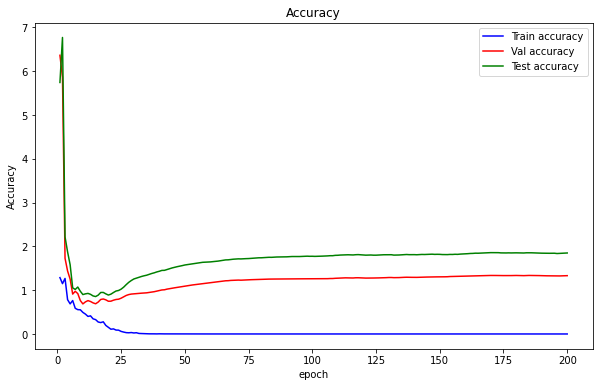

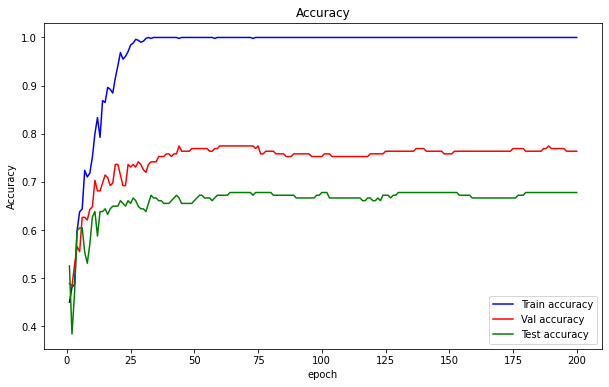



In fold  1
The best validaiton accuracy is:  0.7747252747252747
Happened at epoch:  189
The corresponding test accuracy 0.6779661016949152
The corresponding test AUC is:  0.7552429667519182




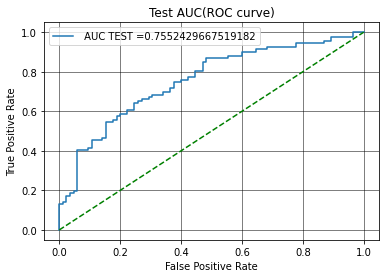

  + Number of params: 228482
Save models
Train Epoch: 1: train loss : 0.98753262	 train accuracy : 0.47013487	 val accuracy : 0.54802260	 test accuracy : 0.48275862	
Train Epoch: 2: train loss : 0.92166305	 train accuracy : 0.49518304	 val accuracy : 0.46327684	 test accuracy : 0.52298851	
Train Epoch: 3: train loss : 0.99226403	 train accuracy : 0.52793834	 val accuracy : 0.52542373	 test accuracy : 0.50000000	
Save models
Train Epoch: 4: train loss : 0.69317210	 train accuracy : 0.63583815	 val accuracy : 0.57627119	 test accuracy : 0.49425287	
Save models
Train Epoch: 5: train loss : 0.72309989	 train accuracy : 0.67437380	 val accuracy : 0.63276836	 test accuracy : 0.54022989	
Train Epoch: 6: train loss : 0.62416303	 train accuracy : 0.68593449	 val accuracy : 0.55932203	 test accuracy : 0.56896552	
Train Epoch: 7: train loss : 0.55862439	 train accuracy : 0.70134875	 val accuracy : 0.54802260	 test accuracy : 0.55747126	
Train Epoch: 8: train loss : 0.55079740	 train accuracy : 0.

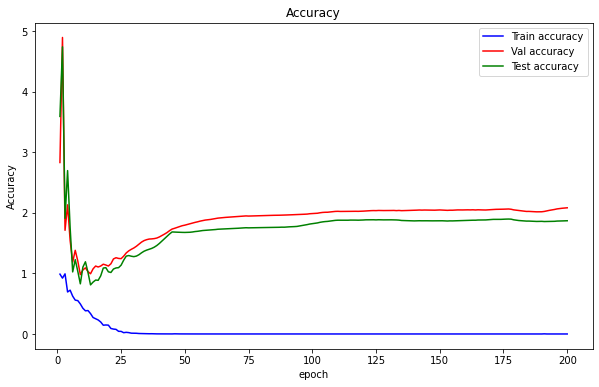

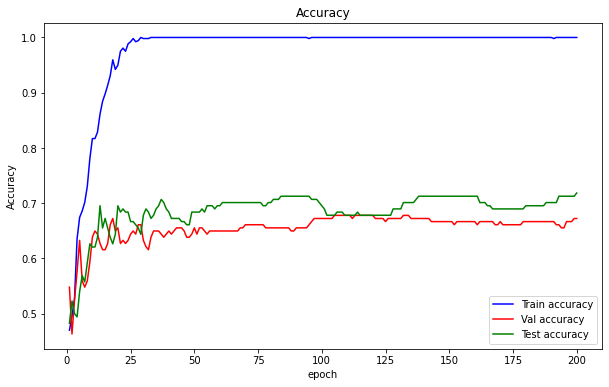



In fold  2
The best validaiton accuracy is:  0.6779661016949152
Happened at epoch:  134
The corresponding test accuracy 0.7011494252873564
The corresponding test AUC is:  0.7282623124917031




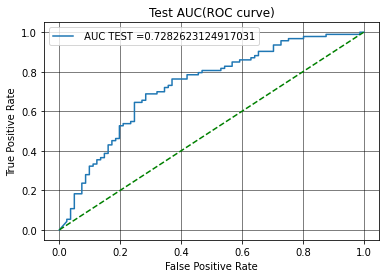

  + Number of params: 228482
Save models
Train Epoch: 1: train loss : 0.98221648	 train accuracy : 0.51901141	 val accuracy : 0.47701149	 test accuracy : 0.43529412	
Save models
Train Epoch: 2: train loss : 1.01404142	 train accuracy : 0.47718631	 val accuracy : 0.55172414	 test accuracy : 0.47647059	
Save models
Train Epoch: 3: train loss : 0.80403173	 train accuracy : 0.59505703	 val accuracy : 0.56321839	 test accuracy : 0.58823529	
Train Epoch: 4: train loss : 0.63731086	 train accuracy : 0.70532319	 val accuracy : 0.55747126	 test accuracy : 0.63529412	
Save models
Train Epoch: 5: train loss : 0.54131389	 train accuracy : 0.75665399	 val accuracy : 0.56321839	 test accuracy : 0.57647059	
Save models
Train Epoch: 6: train loss : 0.49125844	 train accuracy : 0.77376426	 val accuracy : 0.57471264	 test accuracy : 0.60588235	
Save models
Train Epoch: 7: train loss : 0.42562735	 train accuracy : 0.81749049	 val accuracy : 0.59195402	 test accuracy : 0.61764706	
Save models
Train Epoch:

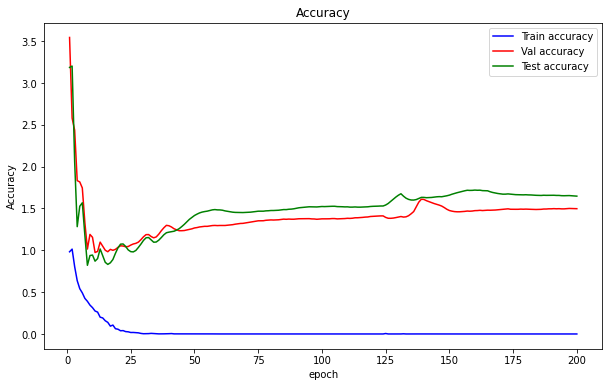

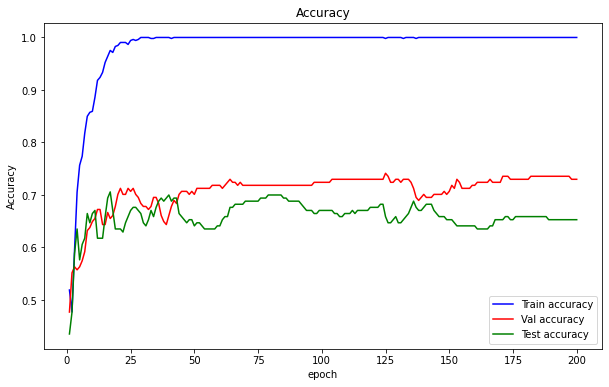



In fold  3
The best validaiton accuracy is:  0.7413793103448276
Happened at epoch:  125
The corresponding test accuracy 0.6588235294117647
The corresponding test AUC is:  0.7401315789473684




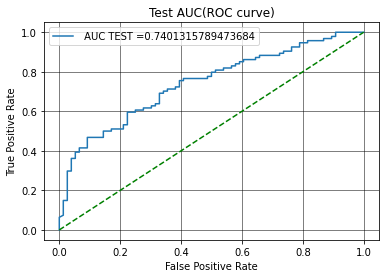

  + Number of params: 228482
Save models
Train Epoch: 1: train loss : 1.03754520	 train accuracy : 0.48592871	 val accuracy : 0.45294118	 test accuracy : 0.44910180	
Save models
Train Epoch: 2: train loss : 1.42367721	 train accuracy : 0.49718574	 val accuracy : 0.51764706	 test accuracy : 0.48502994	
Save models
Train Epoch: 3: train loss : 0.90099370	 train accuracy : 0.54409006	 val accuracy : 0.56470588	 test accuracy : 0.55089820	
Save models
Train Epoch: 4: train loss : 0.90584886	 train accuracy : 0.60600375	 val accuracy : 0.59411765	 test accuracy : 0.56886228	
Train Epoch: 5: train loss : 0.66882384	 train accuracy : 0.63602251	 val accuracy : 0.48823529	 test accuracy : 0.52095808	
Train Epoch: 6: train loss : 0.76469260	 train accuracy : 0.61913696	 val accuracy : 0.51176471	 test accuracy : 0.55089820	
Train Epoch: 7: train loss : 0.64746839	 train accuracy : 0.68292683	 val accuracy : 0.53529412	 test accuracy : 0.59880240	
Train Epoch: 8: train loss : 0.58239710	 train a

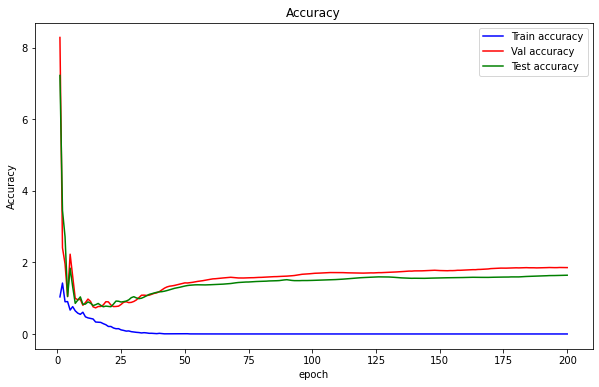

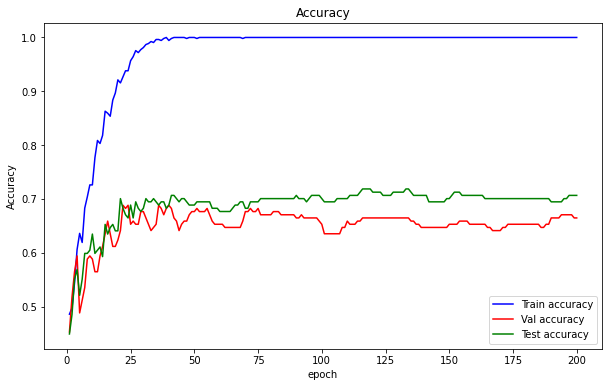



In fold  4
The best validaiton accuracy is:  0.6882352941176471
Happened at epoch:  40
The corresponding test accuracy 0.688622754491018
The corresponding test AUC is:  0.7504347826086957




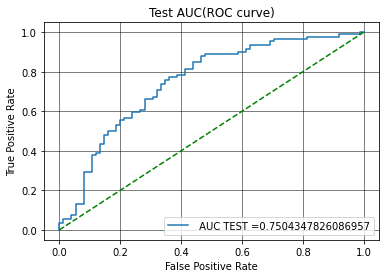

  + Number of params: 228482
Save models
Train Epoch: 1: train loss : 1.13398409	 train accuracy : 0.49328215	 val accuracy : 0.46107784	 test accuracy : 0.51098901	
Save models
Train Epoch: 2: train loss : 0.78881866	 train accuracy : 0.56621881	 val accuracy : 0.49101796	 test accuracy : 0.51098901	
Save models
Train Epoch: 3: train loss : 0.77615744	 train accuracy : 0.62380038	 val accuracy : 0.56886228	 test accuracy : 0.56043956	
Save models
Train Epoch: 4: train loss : 0.56459576	 train accuracy : 0.74856046	 val accuracy : 0.57485030	 test accuracy : 0.58241758	
Save models
Train Epoch: 5: train loss : 0.52763832	 train accuracy : 0.77543186	 val accuracy : 0.59880240	 test accuracy : 0.63186813	
Save models
Train Epoch: 6: train loss : 0.41492608	 train accuracy : 0.81381958	 val accuracy : 0.61676647	 test accuracy : 0.63186813	
Save models
Train Epoch: 7: train loss : 0.39677456	 train accuracy : 0.84452975	 val accuracy : 0.66467066	 test accuracy : 0.65934066	
Save models


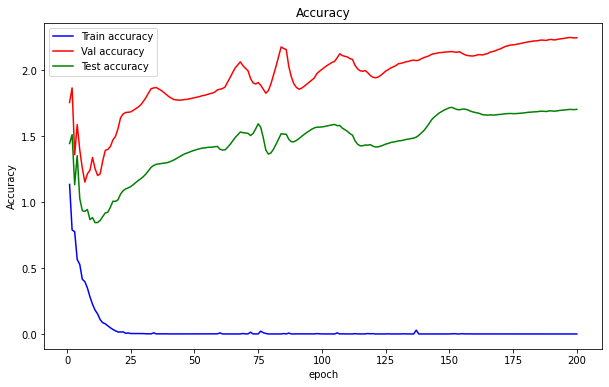

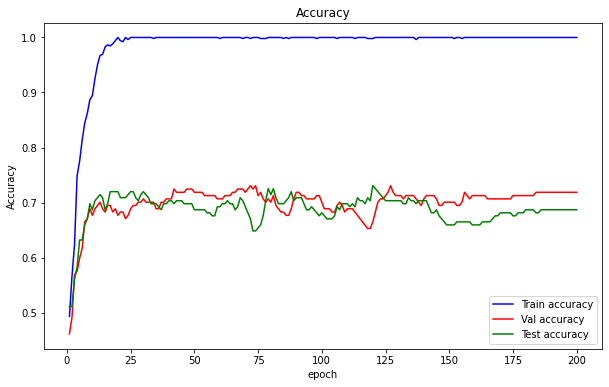



In fold  5
The best validaiton accuracy is:  0.7305389221556886
Happened at epoch:  127
The corresponding test accuracy 0.7032967032967034
The corresponding test AUC is:  0.7835513565891473




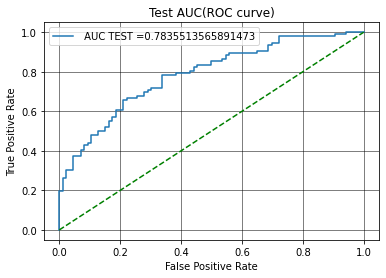

Finish 5-fold training


In [ ]:
########################################### Training ################################################
########################################### Training ################################################
########################################### Training ################################################
for fold in range(1, k_fold+1):
  model = EV_GCN(args.input_dimension, args.num_classes, args.dropout, edge_dropout=args.edropout, hgc=args.hgc, lg=args.lg, edgenet_input_dim=2*phonetic_data.shape[1])
  print('  + Number of params: {}'.format(
    sum([p.data.nelement() for p in model.parameters()])))
  model = nn.parallel.DataParallel(model, device_ids=gpu_ids)
  if args.cuda:
    model = model.cuda()
  optimizer = optim.Adam(model.parameters(), lr = args.lr)

  best_validation_accuracy = 0
  Train_accuracy_list =[]
  Train_loss_list = []
  Val_accuracy_list =[]
  Val_loss_list = []
  Test_accuracy_list =[]
  Test_loss_list = []

  for epoch in range(1, args.nEpochs + 1):

    model, train_target, train_out, train_loss, val_target, val_out, val_loss, test_target, test_out, test_prob, test_loss = train(args, model, data[str(fold)], dist_train[str(fold)], dist_validation[str(fold)], dist_test[str(fold)], optimizer)

    train_accuracy = metrics.accuracy_score(train_target, train_out)
    val_accuracy = metrics.accuracy_score(val_target, val_out)
    test_accuracy = metrics.accuracy_score(test_target, test_out)
    Train_accuracy_list.append(train_accuracy)
    Val_accuracy_list.append(val_accuracy)
    Test_accuracy_list.append(test_accuracy)
    Train_loss_list.append(train_loss)
    Val_loss_list.append(val_loss)
    Test_loss_list.append(test_loss)

    if val_accuracy >=best_validation_accuracy:
      best_epoch = epoch
      best_validation_accuracy = val_accuracy
      corresponding_val_out = val_out
      corresponding_test_accuracy = test_accuracy
      corresponding_test_out = test_out
      corresponding_test_prob = test_prob

      print('Save models')
      save_model(model, save_path, 'EV_GCN_'+str(fold))

    print('Train Epoch: ' + str(epoch) + ': train loss : {:.8f}\t train accuracy : {:.8f}\t val accuracy : {:.8f}\t test accuracy : {:.8f}\t'.format(
      train_loss, train_accuracy, val_accuracy, test_accuracy))
  
  if fold == 1:
    all_fold_val_label = val_target
    all_fold_val_out = corresponding_val_out
    all_fold_test_label = test_target
    all_fold_test_out = corresponding_test_out
    all_fold_test_prob = corresponding_test_prob
  else:
    all_fold_val_label = np.concatenate((all_fold_val_label, val_target),axis = 0)
    all_fold_val_out = np.concatenate((all_fold_val_out, corresponding_val_out),axis = 0)
    all_fold_test_label = np.concatenate((all_fold_test_label, test_target),axis = 0)
    all_fold_test_out = np.concatenate((all_fold_test_out, corresponding_test_out),axis = 0)
    all_fold_test_prob = np.concatenate((all_fold_test_prob, corresponding_test_prob),axis = 0)

  x_axis = list(range(1, len(Train_accuracy_list)+1))
  plt.figure(figsize=(10,6))
  plt.plot(x_axis, Train_loss_list, c='b',label='Train accuracy')
  plt.plot(x_axis, Val_loss_list, c='r',label='Val accuracy')
  plt.plot(x_axis, Test_loss_list, c='g',label='Test accuracy')
  plt.title("Accuracy")
  plt.xlabel("epoch")
  plt.ylabel("Accuracy")
  plt.legend()
  plt.show()

  plt.figure(figsize=(10,6))
  plt.plot(x_axis, Train_accuracy_list, c='b',label='Train accuracy')
  plt.plot(x_axis, Val_accuracy_list, c='r',label='Val accuracy')
  plt.plot(x_axis, Test_accuracy_list, c='g',label='Test accuracy')
  plt.title("Accuracy")
  plt.xlabel("epoch")
  plt.ylabel("Accuracy")
  plt.legend()
  plt.show()


  test_fpr, test_tpr, te_thresholds = roc_curve(test_target, corresponding_test_prob[:,1],pos_label=1)
  test_auc = auc(test_fpr, test_tpr)
  print('\n')
  print('In fold ',str(fold))
  print('The best validaiton accuracy is: ',best_validation_accuracy)
  print('Happened at epoch: ',best_epoch)
  print('The corresponding test accuracy', corresponding_test_accuracy)
  print('The corresponding test AUC is: ',test_auc)
  print('\n')


  plt.grid()
  plt.plot(test_fpr, test_tpr, label=" AUC TEST ="+str(auc(test_fpr, test_tpr)))
  plt.plot([0,1],[0,1],'g--')
  plt.legend()
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.title("Test AUC(ROC curve)")
  plt.grid(color='black', linestyle='-', linewidth=0.5)
  plt.show()

print('Finish 5-fold training')


The best validation accuracy is  0.7229885057471265
The corresponding test accuracy is  0.6862068965517242
The corresponding test AUC is:  0.7478148362654822


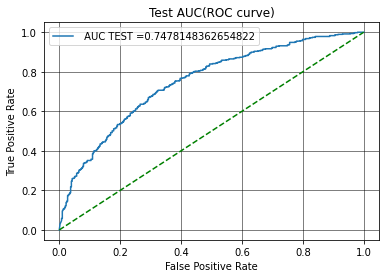

In [ ]:
val_accuracy = metrics.accuracy_score(all_fold_val_label, all_fold_val_out)
test_accuracy = metrics.accuracy_score(all_fold_test_label, all_fold_test_out)
test_fpr, test_tpr, te_thresholds = roc_curve(all_fold_test_label, all_fold_test_prob[:,1],pos_label=1)
test_auc = auc(test_fpr, test_tpr)
print('The best validation accuracy is ',val_accuracy)
print('The corresponding test accuracy is ',test_accuracy)
print('The corresponding test AUC is: ',test_auc)
plt.grid()
plt.plot(test_fpr, test_tpr, label=" AUC TEST ="+str(auc(test_fpr, test_tpr)))
plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Test AUC(ROC curve)")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.show()

In [ ]:
print("build EV_GCN pytorch")

model_1 = EV_GCN(args.input_dimension, args.num_classes, args.dropout, edge_dropout=args.edropout, hgc=args.hgc, lg=args.lg, edgenet_input_dim=2*phonetic_data.shape[1])
model_2 = EV_GCN(args.input_dimension, args.num_classes, args.dropout, edge_dropout=args.edropout, hgc=args.hgc, lg=args.lg, edgenet_input_dim=2*phonetic_data.shape[1])
model_3 = EV_GCN(args.input_dimension, args.num_classes, args.dropout, edge_dropout=args.edropout, hgc=args.hgc, lg=args.lg, edgenet_input_dim=2*phonetic_data.shape[1])
model_4 = EV_GCN(args.input_dimension, args.num_classes, args.dropout, edge_dropout=args.edropout, hgc=args.hgc, lg=args.lg, edgenet_input_dim=2*phonetic_data.shape[1])
model_5 = EV_GCN(args.input_dimension, args.num_classes, args.dropout, edge_dropout=args.edropout, hgc=args.hgc, lg=args.lg, edgenet_input_dim=2*phonetic_data.shape[1])

gpu_ids = range(args.ngpu)
model_1 = nn.parallel.DataParallel(model_1, device_ids=gpu_ids)
model_2 = nn.parallel.DataParallel(model_2, device_ids=gpu_ids)
model_3 = nn.parallel.DataParallel(model_3, device_ids=gpu_ids)
model_4 = nn.parallel.DataParallel(model_4, device_ids=gpu_ids)
model_5 = nn.parallel.DataParallel(model_5, device_ids=gpu_ids)

print('  + Number of params: {}'.format(
    sum([p.data.nelement() for p in model_1.parameters()])))
if args.cuda:
    model_1 = model_1.cuda()
    model_2 = model_2.cuda()
    model_3 = model_3.cuda()
    model_4 = model_4.cuda()
    model_5 = model_5.cuda()

model_1 = load_model(model_1, save_path, 'EV_GCN_' + str(1))
model_2 = load_model(model_2, save_path, 'EV_GCN_' + str(2))
model_3 = load_model(model_3, save_path, 'EV_GCN_' + str(3))
model_4 = load_model(model_4, save_path, 'EV_GCN_' + str(4))
model_5 = load_model(model_5, save_path, 'EV_GCN_' + str(5))


build EV_GCN pytorch
  + Number of params: 228482


In [ ]:
for fold in range(1, k_fold+1):
    if fold == 1:
        model = model_1.eval()
    elif fold == 2:
        model = model_2.eval()
    elif fold == 3:
        model = model_3.eval()
    elif fold == 4:
        model = model_4.eval()
    elif fold == 5:
        model = model_5.eval()
    
    fold_test_index = dist_test[str(fold)]

    model.eval()

    data_test = torch.from_numpy(data[str(fold)][0])
    data_test = Variable(data_test, requires_grad=False)
    data_test = data_test.float()

    target = torch.from_numpy(data[str(fold)][1])
    target = target.float().long()

    edge_index = torch.from_numpy(data[str(fold)][2])
    edge_index = Variable(edge_index, requires_grad=False)

    edgenet_input = torch.from_numpy(data[str(fold)][3])
    edgenet_input = Variable(edgenet_input, requires_grad=False)
    edgenet_input = edgenet_input.float()

    if args.cuda:
        data_test, target, edge_index, edgenet_input = data_test.cuda(), target.cuda(), edge_index.cuda(), edgenet_input.cuda()

    out, _ = model(data_test, edge_index, edgenet_input)
    print(data_test)
    print(data_test.shape)
    out = out[fold_test_index, :]
    target = target[fold_test_index, :]

    out_prob = torch.exp(out)
    out = torch.max(out, 1)[1]
    target = torch.max(target, 1)[1]
    target = target.cpu().numpy()
    out = out.cpu().numpy()
    out_prob = out_prob.cpu().detach().numpy()

    if fold == 1:
      EV_GCN_labels_concat = target
      EV_GCN_results_concat = out
      EV_GCN_results_prob_concat = out_prob
    else:
      EV_GCN_labels_concat = np.concatenate((EV_GCN_labels_concat, target),axis = 0)
      EV_GCN_results_concat = np.concatenate((EV_GCN_results_concat, out),axis = 0)
      EV_GCN_results_prob_concat = np.concatenate((EV_GCN_results_prob_concat, out_prob),axis = 0)

EV_GCN_labels_concat = 1 - EV_GCN_labels_concat
EV_GCN_results_concat = 1 - EV_GCN_results_concat
EV_GCN_results_prob_concat_change = np.zeros_like(EV_GCN_results_prob_concat)
EV_GCN_results_prob_concat_change[:,0] = EV_GCN_results_prob_concat[:,1]
EV_GCN_results_prob_concat_change[:,1] = EV_GCN_results_prob_concat[:,0]

test_accuracy = metrics.accuracy_score(EV_GCN_labels_concat, EV_GCN_results_concat)
print(test_accuracy)
print(EV_GCN_labels_concat)
print(EV_GCN_results_concat)
print(EV_GCN_results_prob_concat_change)

tensor([[-0.3924,  0.1374,  0.2514,  ...,  1.1264,  1.4054,  0.8924],
        [-0.0777,  0.3751, -0.2741,  ..., -0.4920,  0.5400, -0.5119],
        [ 0.2476, -0.0319, -0.3544,  ...,  0.2812, -0.3113, -0.3823],
        ...,
        [-0.7046, -0.1315, -0.7555,  ...,  0.0781, -0.9129, -1.5360],
        [-1.3318, -1.3023,  2.1218,  ...,  0.2083, -0.1181, -1.2026],
        [-0.1303, -0.0290, -0.7132,  ..., -0.1546,  1.5289, -0.3309]],
       device='cuda:0')
torch.Size([870, 6000])
tensor([[-0.3924,  0.1374,  0.2514,  ...,  1.0451,  1.1192,  1.1264],
        [-0.0777,  0.3751, -0.2741,  ..., -0.0035, -0.3561, -0.4920],
        [ 0.2476, -0.0319, -0.3544,  ...,  0.8084, -0.7099,  0.2812],
        ...,
        [-0.7046, -0.1315, -0.7555,  ...,  0.2162, -0.8348,  0.0781],
        [-1.3318, -1.3023,  2.1218,  ..., -1.2332,  0.0461,  0.2083],
        [-0.1303, -0.0290, -0.7132,  ...,  0.6270, -1.2531, -0.1546]],
       device='cuda:0')
torch.Size([870, 6000])
tensor([[-0.3924,  0.2514, -0.3025, 

Ensemble  1


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Fitting estimator with 19900 features.
Fitting estimator with 19800 features.
Fitting estimator with 19700 features.
Fitting estimator with 19600 features.
Fitting estimator with 19500 features.
Fitting estimator with 19400 features.
Fitting estimator with 19300 features.
Fitting estimator with 19200 features.
Fitting estimator with 19100 features.
Fitting estimator with 19000 features.
Fitting estimator with 18900 features.
Fitting estimator with 18800 features.
Fitting estimator with 18700 features.
Fitting estimator with 18600 features.
Fitting estimator with 18500 features.
Fitting estimator with 18400 features.
Fitting estimator with 18300 features.
Fitting estimator with 18200 features.
Fitting estimator with 18100 features.
Fitting estimator with 18000 features.
Fitting estimator with 17900 features.
Fitting estimator with 17800 features.
Fitting estimator with 17700 features.
Fitting estimator with 17600 features.
Fitting estimator with 17500 features.
Fitting estimator with 17

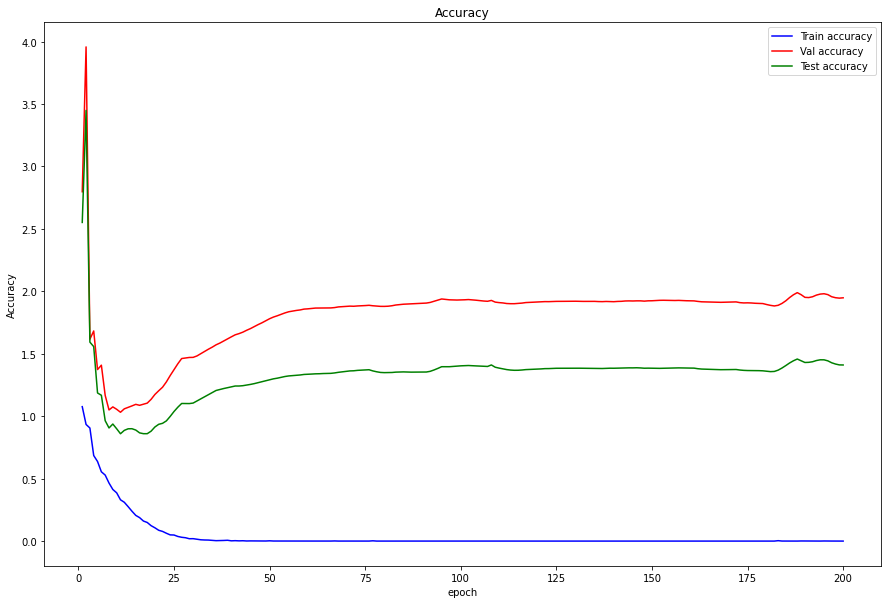

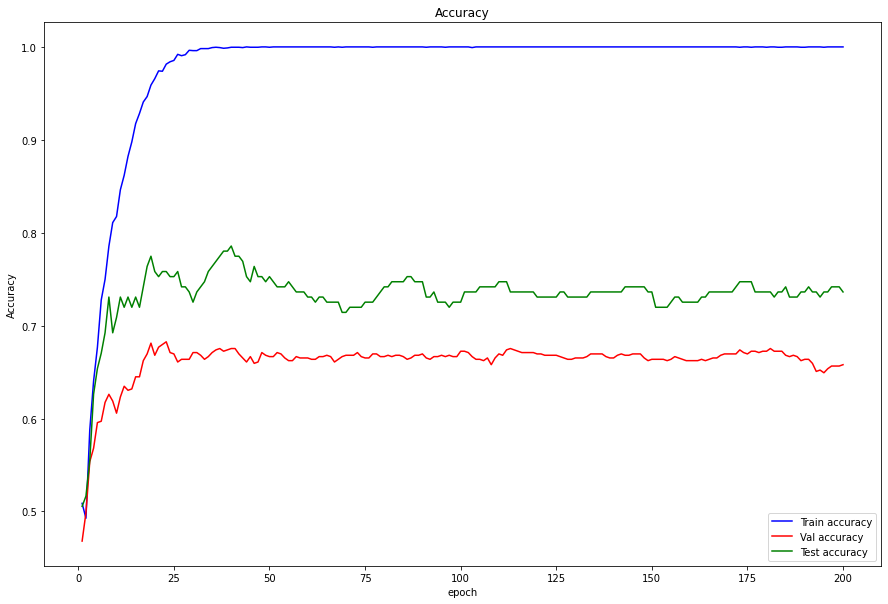



In ensemble  1
The best validaiton accuracy is:  0.6826086956521739
Happened at epoch:  23
The corresponding test accuracy 0.7582417582417582
The corresponding test AUC is:  0.8309108527131784




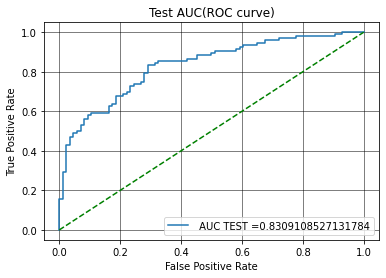



Ensemble  2
Fitting estimator with 19900 features.


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Fitting estimator with 19800 features.
Fitting estimator with 19700 features.
Fitting estimator with 19600 features.
Fitting estimator with 19500 features.
Fitting estimator with 19400 features.
Fitting estimator with 19300 features.
Fitting estimator with 19200 features.
Fitting estimator with 19100 features.
Fitting estimator with 19000 features.
Fitting estimator with 18900 features.
Fitting estimator with 18800 features.
Fitting estimator with 18700 features.
Fitting estimator with 18600 features.
Fitting estimator with 18500 features.
Fitting estimator with 18400 features.
Fitting estimator with 18300 features.
Fitting estimator with 18200 features.
Fitting estimator with 18100 features.
Fitting estimator with 18000 features.
Fitting estimator with 17900 features.
Fitting estimator with 17800 features.
Fitting estimator with 17700 features.
Fitting estimator with 17600 features.
Fitting estimator with 17500 features.
Fitting estimator with 17400 features.
Fitting estimator with 17

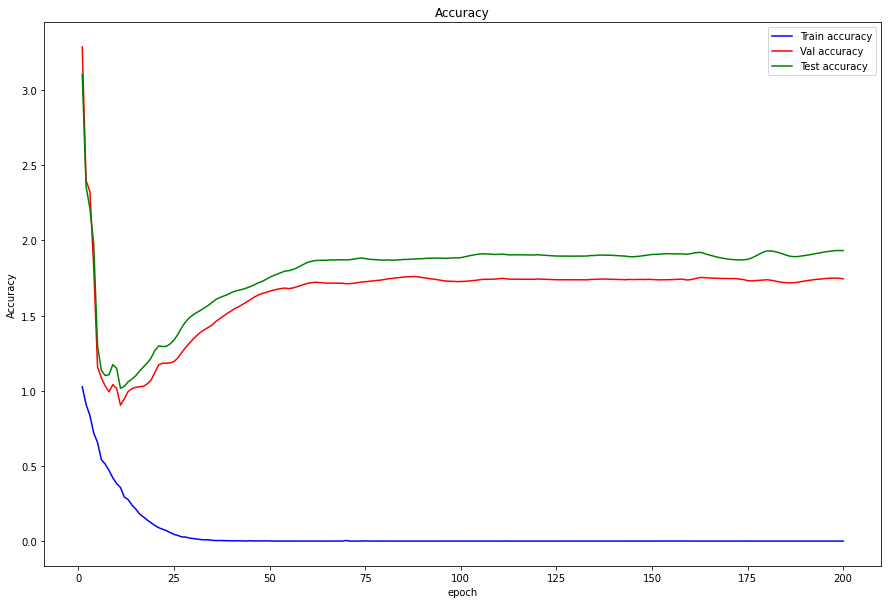

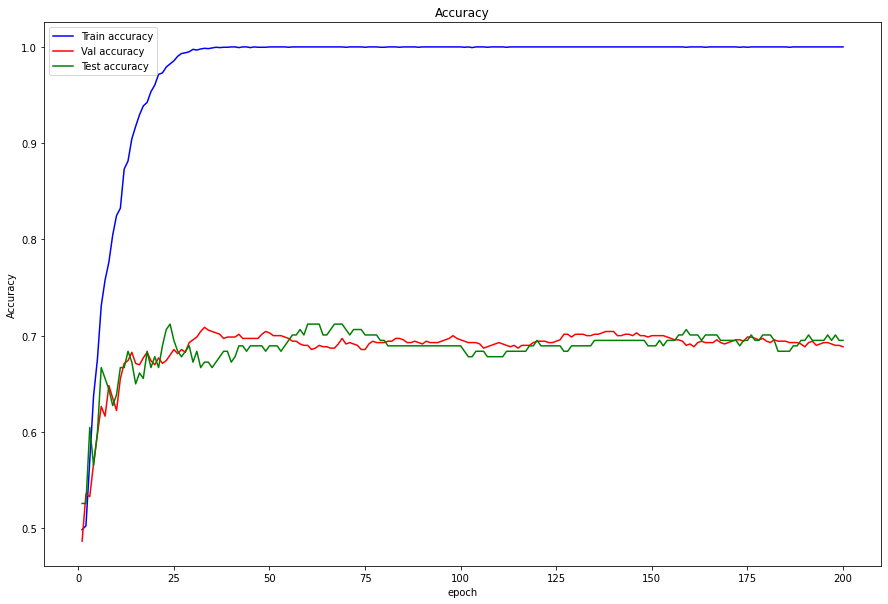



In ensemble  2
The best validaiton accuracy is:  0.7085137085137085
Happened at epoch:  33
The corresponding test accuracy 0.672316384180791
The corresponding test AUC is:  0.7641943734015345




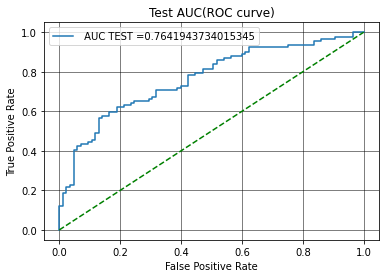



Ensemble  3
Fitting estimator with 19900 features.


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Fitting estimator with 19800 features.
Fitting estimator with 19700 features.
Fitting estimator with 19600 features.
Fitting estimator with 19500 features.
Fitting estimator with 19400 features.
Fitting estimator with 19300 features.
Fitting estimator with 19200 features.
Fitting estimator with 19100 features.
Fitting estimator with 19000 features.
Fitting estimator with 18900 features.
Fitting estimator with 18800 features.
Fitting estimator with 18700 features.
Fitting estimator with 18600 features.
Fitting estimator with 18500 features.
Fitting estimator with 18400 features.
Fitting estimator with 18300 features.
Fitting estimator with 18200 features.
Fitting estimator with 18100 features.
Fitting estimator with 18000 features.
Fitting estimator with 17900 features.
Fitting estimator with 17800 features.
Fitting estimator with 17700 features.
Fitting estimator with 17600 features.
Fitting estimator with 17500 features.
Fitting estimator with 17400 features.
Fitting estimator with 17

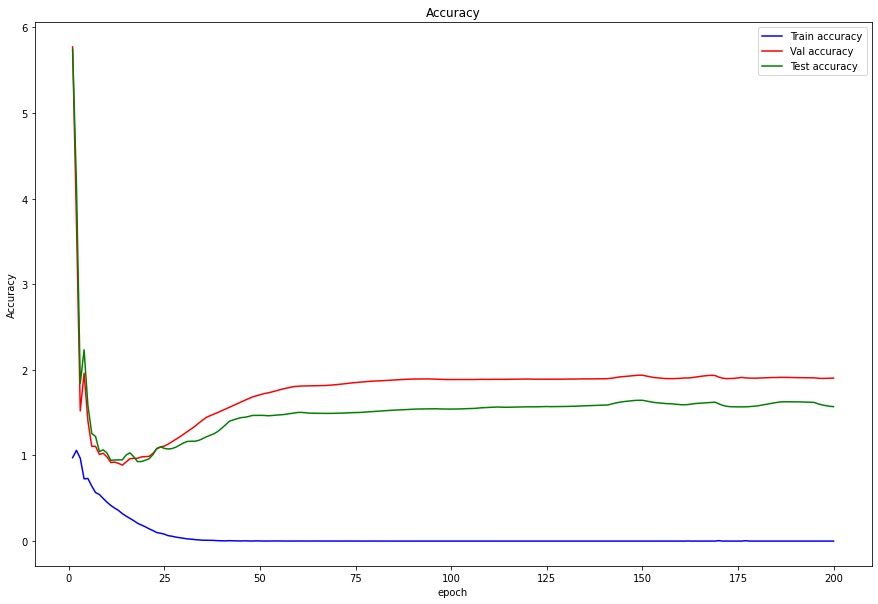

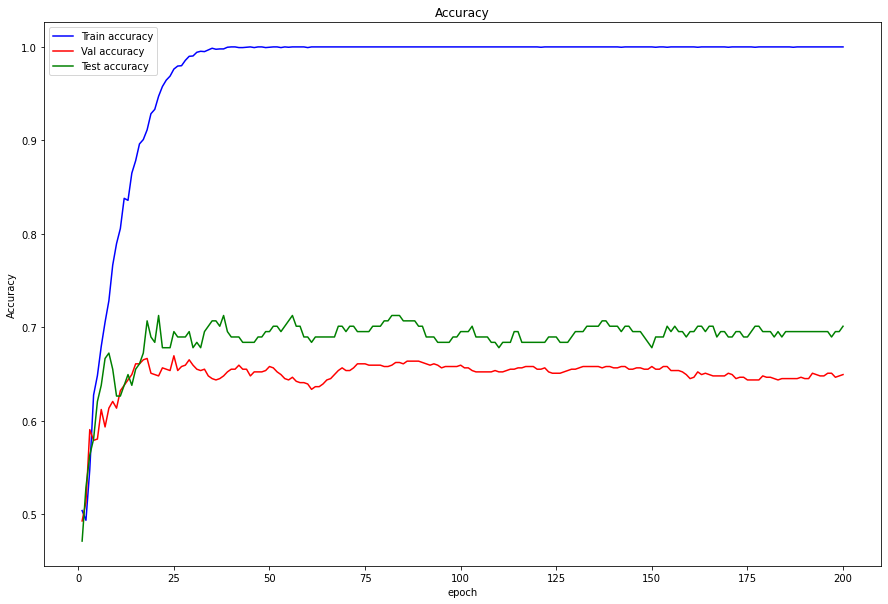



In ensemble  3
The best validaiton accuracy is:  0.6695402298850575
Happened at epoch:  25
The corresponding test accuracy 0.6954022988505747
The corresponding test AUC is:  0.7589273861675295




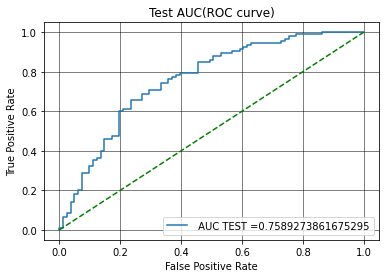



Ensemble  4
Fitting estimator with 19900 features.


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Fitting estimator with 19800 features.
Fitting estimator with 19700 features.
Fitting estimator with 19600 features.
Fitting estimator with 19500 features.
Fitting estimator with 19400 features.
Fitting estimator with 19300 features.
Fitting estimator with 19200 features.
Fitting estimator with 19100 features.
Fitting estimator with 19000 features.
Fitting estimator with 18900 features.
Fitting estimator with 18800 features.
Fitting estimator with 18700 features.
Fitting estimator with 18600 features.
Fitting estimator with 18500 features.
Fitting estimator with 18400 features.
Fitting estimator with 18300 features.
Fitting estimator with 18200 features.
Fitting estimator with 18100 features.
Fitting estimator with 18000 features.
Fitting estimator with 17900 features.
Fitting estimator with 17800 features.
Fitting estimator with 17700 features.
Fitting estimator with 17600 features.
Fitting estimator with 17500 features.
Fitting estimator with 17400 features.
Fitting estimator with 17

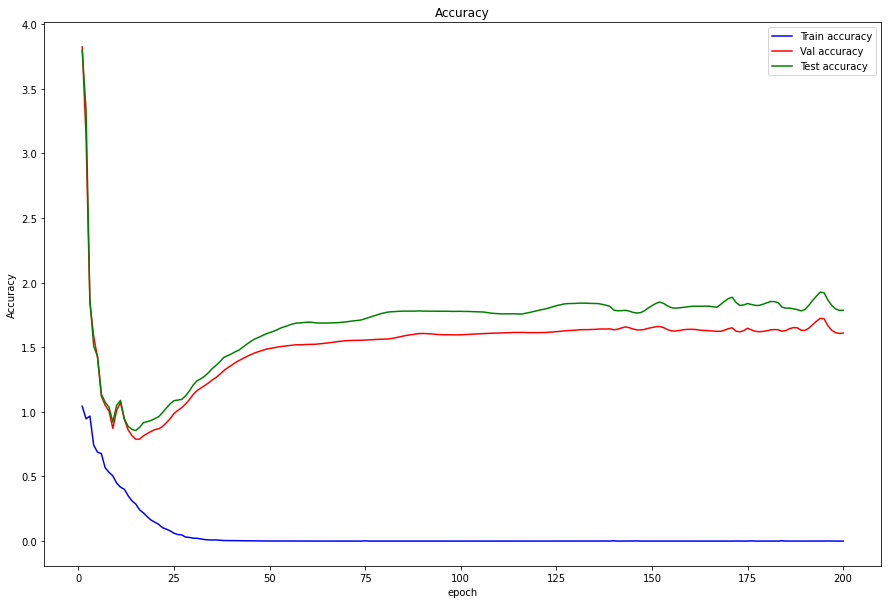

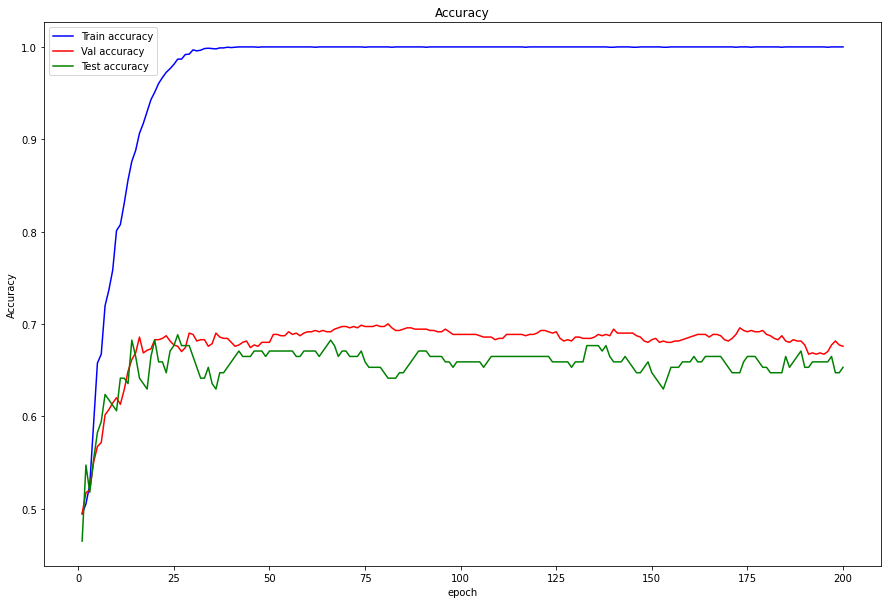



In ensemble  4
The best validaiton accuracy is:  0.7
Happened at epoch:  81
The corresponding test accuracy 0.6411764705882353
The corresponding test AUC is:  0.7266237402015678




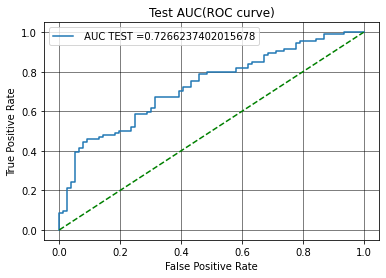



Ensemble  5
Fitting estimator with 19900 features.


/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/model_selection/_split.py:676: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(


Fitting estimator with 19800 features.
Fitting estimator with 19700 features.
Fitting estimator with 19600 features.
Fitting estimator with 19500 features.
Fitting estimator with 19400 features.
Fitting estimator with 19300 features.
Fitting estimator with 19200 features.
Fitting estimator with 19100 features.
Fitting estimator with 19000 features.
Fitting estimator with 18900 features.
Fitting estimator with 18800 features.
Fitting estimator with 18700 features.
Fitting estimator with 18600 features.
Fitting estimator with 18500 features.
Fitting estimator with 18400 features.
Fitting estimator with 18300 features.
Fitting estimator with 18200 features.
Fitting estimator with 18100 features.
Fitting estimator with 18000 features.
Fitting estimator with 17900 features.
Fitting estimator with 17800 features.
Fitting estimator with 17700 features.
Fitting estimator with 17600 features.
Fitting estimator with 17500 features.
Fitting estimator with 17400 features.
Fitting estimator with 17

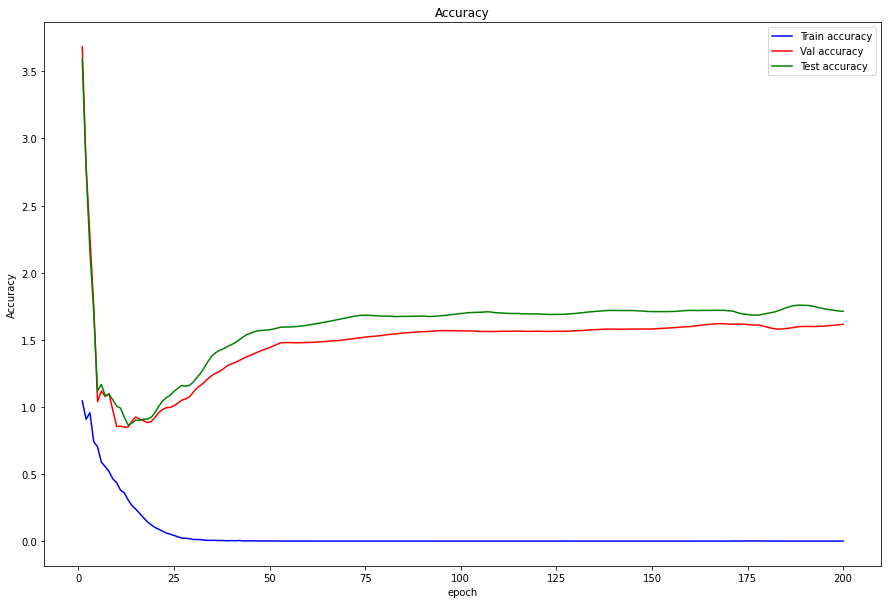

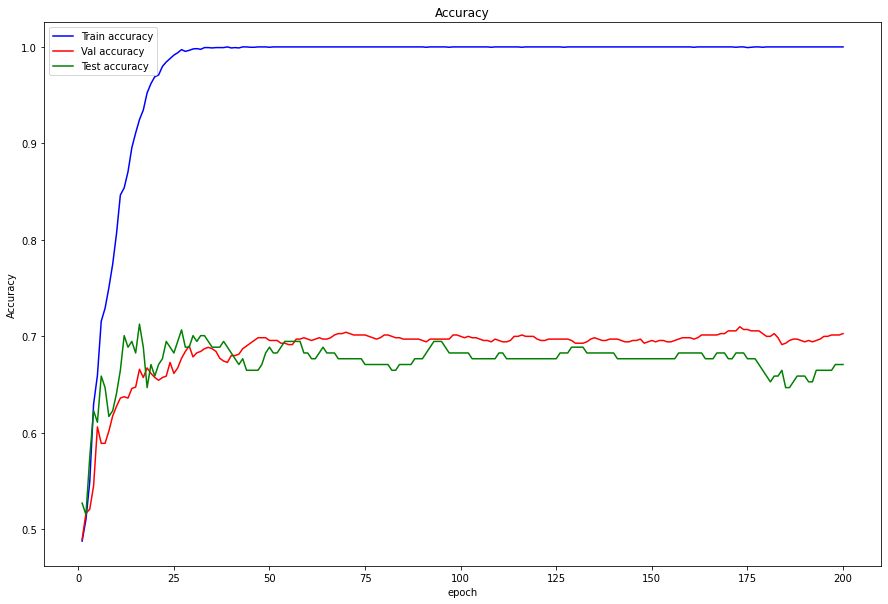



In ensemble  5
The best validaiton accuracy is:  0.7098150782361309
Happened at epoch:  173
The corresponding test accuracy 0.6826347305389222
The corresponding test AUC is:  0.7798550724637682




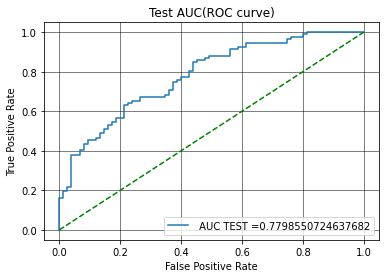



The Max voting test accuracy is:  0.6908045977011494
The test AUC is:  0.7674401304987752






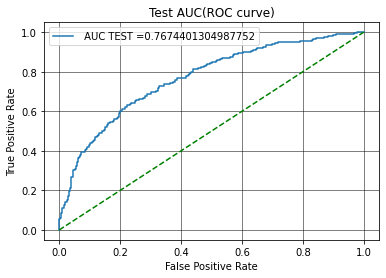

In [ ]:
torch.cuda.empty_cache()
torch.manual_seed(args.seed)
if args.cuda:
    torch.cuda.manual_seed(args.seed)
############################################### Max voting ###############################################################
############################################### Max voting ###############################################################
############################################### Max voting ###############################################################
dist_ensemble_val_label = {}
dist_ensemble_val_result = {}
dist_ensemble_test_label = {}
dist_ensemble_test_result = {}
dist_ensemble_test_prob = {}

for ensemble_fold in range(5):
  print('Ensemble ',ensemble_fold+1)
  save_ensemble_models_path = save_path + 'Max_voting/EV_GCN/'
  dist_train = {}
  dist_validation = {}
  dist_test = {}
  for i in range(k_fold):
    dist_train[str(i + 1)] = []
    dist_validation[str(i + 1)] = []
    dist_test[str(i + 1)] = []
  test_name = {}
  for i in range(len(unique_sites)):
    test_name[unique_sites[i]] = []
  for each_site in unique_sites:
    index_site = get_index(sites, each_site)
    label = np.zeros((len(index_site)))
    for i in range(len(index_site)):
      index = index_site[i]
      label[i] = int(labels[int(index)])
    test_name_list = test_name[each_site]
    ########################################### StratifiedKFold ####################################################
    sfolder = StratifiedKFold(n_splits=k_fold,random_state=0,shuffle=True)
    group = 0
    for train, validation in sfolder.split(index_site,label):
      if group == ensemble_fold:
        for j in validation:
          name = index_site[j]
          dist_test['1'].append(name)
          dist_test['2'].append(name)
          dist_test['3'].append(name)
          dist_test['4'].append(name)
          dist_test['5'].append(name)
          test_name_list.append(name)
      group = group + 1
    test_name[each_site] = test_name_list

  for each_site in unique_sites:
    if ensemble_fold == 0:

      index_site = get_index(sites, each_site)
      label = np.zeros((len(index_site)))
      for i in range(len(index_site)):
        index = index_site[i]
        label[i] = int(labels[int(index)])
      test_name_list = test_name[each_site]
      index_site_new = []
      label_new = np.zeros((len(index_site) - len(test_name_list)))
      position = 0
      for x in range(len(index_site)):
        sample_name = index_site[x]
        if sample_name in test_name_list:
          c=0
        else:
          index_site_new.append(sample_name)
          label_new[position] = label[x]
          position = position + 1
      if each_site == 'CMU':  # ONLY 4 AUTISM SAMPLES AND 4 TD SAMPLES, CAN NOT BE DEVIDED INTO 5 GROUPS
        group_autism_val = []
        group_autism_train = []
        group_TD_val = []
        group_TD_train = []
        autism_validation_number = len(label_new[label_new ==1])/4
        TD_validation_number = len(label_new[label_new ==0]) / 4
        for j in range(len(label_new)):
          if label_new[j] == 1:
            if len(group_autism_val)<autism_validation_number:
              group_autism_val.append(index_site_new[j])
            else:
              group_autism_train.append(index_site_new[j])
          else:
            if len(group_TD_val)<TD_validation_number:
              group_TD_val.append(index_site_new[j])
            else:
              group_TD_train.append(index_site_new[j])

        dist_validation['1'] = dist_validation['1'] + group_autism_val + group_TD_val
        dist_validation['2'] = dist_validation['2'] + group_autism_val + group_TD_val
        dist_validation['3'] = dist_validation['3'] + group_autism_val + group_TD_val
        dist_validation['4'] = dist_validation['4'] + group_autism_val + group_TD_val
        dist_validation['5'] = dist_validation['5'] + group_autism_val + group_TD_val
        dist_train['1'] = dist_train['1'] + group_autism_train + group_TD_train
        dist_train['2'] = dist_train['2'] + group_autism_train + group_TD_train
        dist_train['3'] = dist_train['3'] + group_autism_train + group_TD_train
        dist_train['4'] = dist_train['4'] + group_autism_train + group_TD_train
        dist_train['5'] = dist_train['5'] + group_autism_train + group_TD_train
      else:
        ########################################### StratifiedKFold ####################################################
        sfolder = StratifiedKFold(n_splits=k_fold, random_state=0, shuffle=True)
        group = 0
        for train, validation in sfolder.split(index_site_new, label_new):

          for i in train:
            name = index_site_new[i]
            dist_train[str(group + 1)].append(name)
          for j in validation:
            name = index_site_new[j]
            dist_validation[str(group + 1)].append(name)
          group = group + 1
    else:

      index_site = get_index(sites, each_site)
      label = np.zeros((len(index_site)))
      for i in range(len(index_site)):
        index = index_site[i]
        label[i] = int(labels[int(index)])
      test_name_list = test_name[each_site]
      index_site_new = []
      label_new = np.zeros((len(index_site) - len(test_name_list)))
      position = 0
      for x in range(len(index_site)):
        sample_name = index_site[x]
        if sample_name in test_name_list:
          c=0
        else:
          index_site_new.append(sample_name)
          label_new[position] = label[x]
          position = position + 1
      ########################################### StratifiedKFold ####################################################
      sfolder = StratifiedKFold(n_splits=k_fold,random_state=0,shuffle=True)
      group = 0
      for train, validation in sfolder.split(index_site_new,label_new):

        for i in train:
          name = index_site_new[i]
          dist_train[str(group + 1)].append(name)
        for j in validation:
          name = index_site_new[j]
          dist_validation[str(group + 1)].append(name)
        group = group+1
  
  
  data = {}

  for fold in range(1, k_fold+1):
    data[str(fold)] = []
    selector_fMRI = feature_selection_fMRI(fMRI_images, labels, dist_train[str(fold)], new_number_features_fMRI)
    selector_sMRI = feature_selection_sMRI(sMRI_features, labels, dist_train[str(fold)], new_number_features_sMRI)

    new_fMRI_data = selector_fMRI.transform(fMRI_images)
    new_sMRI_data = selector_sMRI.transform(sMRI_features)
    ################################################# combine ##########################################
    sMRI_fMRI_combine = np.concatenate((new_sMRI_data, new_fMRI_data), axis = 1)
    selector_combine = feature_selection_fMRI(sMRI_fMRI_combine, labels, dist_train[str(fold)], new_number_features_combine)
    fold_data = selector_combine.transform(sMRI_fMRI_combine)

    n = fold_data.shape[0]
    num_edge = n * n
    edge_index = np.zeros([2, num_edge], dtype=np.int64)
    edgenet_input = np.zeros([num_edge, 2*phonetic_data.shape[1]], dtype=np.float32)  
    aff_score = np.zeros(num_edge, dtype=np.float32)

    aff_adj = get_static_affinity_adj(fold_data, pd_dict)  

    flatten_ind = 0
    for i in range(n): 
      for j in range(n):
        edge_index[:, flatten_ind] = [i, j]
        edgenet_input[flatten_ind] = np.concatenate((phonetic_data[i], phonetic_data[j]))
        aff_score[flatten_ind] = aff_adj[i][j]
        flatten_ind += 1


    keep_ind = np.where(aff_score > 1.1)[0]
    edge_index = edge_index[:, keep_ind]
    edgenet_input = edgenet_input[keep_ind]
    edgenet_input = (edgenet_input- edgenet_input.mean(axis=0)) / edgenet_input.std(axis=0)

    data[str(fold)].append(fold_data)
    data[str(fold)].append(EV_GCN_labels)
    data[str(fold)].append(edge_index)
    data[str(fold)].append(edgenet_input)




  ############################################### Train ###############################################################
  ############################################### Train ###############################################################
  ############################################### Train ###############################################################

  model_1 = EV_GCN(args.input_dimension, args.num_classes, args.dropout, edge_dropout=args.edropout, hgc=args.hgc, lg=args.lg, edgenet_input_dim=2*phonetic_data.shape[1])
  model_2 = EV_GCN(args.input_dimension, args.num_classes, args.dropout, edge_dropout=args.edropout, hgc=args.hgc, lg=args.lg, edgenet_input_dim=2*phonetic_data.shape[1])
  model_3 = EV_GCN(args.input_dimension, args.num_classes, args.dropout, edge_dropout=args.edropout, hgc=args.hgc, lg=args.lg, edgenet_input_dim=2*phonetic_data.shape[1])
  model_4 = EV_GCN(args.input_dimension, args.num_classes, args.dropout, edge_dropout=args.edropout, hgc=args.hgc, lg=args.lg, edgenet_input_dim=2*phonetic_data.shape[1])
  model_5 = EV_GCN(args.input_dimension, args.num_classes, args.dropout, edge_dropout=args.edropout, hgc=args.hgc, lg=args.lg, edgenet_input_dim=2*phonetic_data.shape[1])

  gpu_ids = range(args.ngpu)
  model_1 = nn.parallel.DataParallel(model_1, device_ids=gpu_ids)
  model_2 = nn.parallel.DataParallel(model_2, device_ids=gpu_ids)
  model_3 = nn.parallel.DataParallel(model_3, device_ids=gpu_ids)
  model_4 = nn.parallel.DataParallel(model_4, device_ids=gpu_ids)
  model_5 = nn.parallel.DataParallel(model_5, device_ids=gpu_ids)
  train = train_EV_GCN

  print('  + Number of params: {}'.format(
      sum([p.data.nelement() for p in model_1.parameters()])))
  if args.cuda:
      model_1 = model_1.cuda()
      model_2 = model_2.cuda()
      model_3 = model_3.cuda()
      model_4 = model_4.cuda()
      model_5 = model_5.cuda()

  optimizer_1 = optim.Adam(model_1.parameters(), lr = args.lr, weight_decay=args.wd)
  optimizer_2 = optim.Adam(model_2.parameters(), lr = args.lr, weight_decay=args.wd)
  optimizer_3 = optim.Adam(model_3.parameters(), lr = args.lr, weight_decay=args.wd)
  optimizer_4 = optim.Adam(model_4.parameters(), lr = args.lr, weight_decay=args.wd)
  optimizer_5 = optim.Adam(model_5.parameters(), lr = args.lr, weight_decay=args.wd)

  Train_accuracy_list =[]
  Train_loss_list = []
  Val_accuracy_list =[]
  Val_loss_list = []
  Test_accuracy_list =[]
  Test_loss_list = []
  best_validation_accuracy = 0

  for epoch in range(1, args.nEpochs + 1):


    model_1, train_target_1, train_out_1, train_loss_1, val_target_1, val_out_1, val_loss_1, test_target_1, test_out_1, test_prob_1, test_loss_1 = train(args, model_1, data['1'], dist_train['1'], dist_validation['1'], dist_test['1'], optimizer_1)
    model_2, train_target_2, train_out_2, train_loss_2, val_target_2, val_out_2, val_loss_2, test_target_2, test_out_2, test_prob_2, test_loss_2 = train(args, model_2, data['2'], dist_train['2'], dist_validation['2'], dist_test['2'], optimizer_2)
    model_3, train_target_3, train_out_3, train_loss_3, val_target_3, val_out_3, val_loss_3, test_target_3, test_out_3, test_prob_3, test_loss_3 = train(args, model_3, data['3'], dist_train['3'], dist_validation['3'], dist_test['3'], optimizer_3)
    model_4, train_target_4, train_out_4, train_loss_4, val_target_4, val_out_4, val_loss_4, test_target_4, test_out_4, test_prob_4, test_loss_4 = train(args, model_4, data['4'], dist_train['4'], dist_validation['4'], dist_test['4'], optimizer_4)
    model_5, train_target_5, train_out_5, train_loss_5, val_target_5, val_out_5, val_loss_5, test_target_5, test_out_5, test_prob_5, test_loss_5 = train(args, model_5, data['5'], dist_train['5'], dist_validation['5'], dist_test['5'], optimizer_5)

    train_target_all = np.concatenate((train_target_1, train_target_2, train_target_3, train_target_4, train_target_5),axis = 0)
    train_out_all = np.concatenate((train_out_1, train_out_2, train_out_3, train_out_4, train_out_5),axis = 0)
    train_loss = (train_loss_1 + train_loss_2 + train_loss_3 + train_loss_4 + train_loss_5)/5
    val_target_all = np.concatenate((val_target_1, val_target_2, val_target_3, val_target_4, val_target_5),axis = 0)
    val_out_all = np.concatenate((val_out_1, val_out_2, val_out_3, val_out_4, val_out_5),axis = 0)
    val_loss = (val_loss_1 + val_loss_2 + val_loss_3 + val_loss_4 + val_loss_5)/5
    test_target_all = test_target_1 # test_target_1 = test_target_2 = test_target_3 = test_target_4 = test_target_5
    test_out_all = test_out_1 + test_out_2 + test_out_3 + test_out_4 + test_out_5
    test_prob_all = (test_prob_1 + test_prob_2 + test_prob_3 + test_prob_4 + test_prob_5)/5
    test_loss = (test_loss_1 + test_loss_2 + test_loss_3 + test_loss_4 + test_loss_5)/5

    test_results_binary = np.zeros_like((test_out_all))
    test_results_binary[test_out_all<2.5] = 0
    test_results_binary[test_out_all>=2.5] = 1

    train_accuracy = metrics.accuracy_score(train_target_all, train_out_all)
    val_accuracy = metrics.accuracy_score(val_target_all, val_out_all)
    test_accuracy = metrics.accuracy_score(test_target_all, test_results_binary)
    Train_accuracy_list.append(train_accuracy)
    Val_accuracy_list.append(val_accuracy)
    Test_accuracy_list.append(test_accuracy)
    Train_loss_list.append(train_loss)
    Val_loss_list.append(val_loss)
    Test_loss_list.append(test_loss)

    if val_accuracy >=best_validation_accuracy:
      best_epoch = epoch
      best_validation_accuracy = val_accuracy
      corresponding_test_accuracy = test_accuracy
      corresponding_test_prob = test_prob_all
      corresponding_test_labels = test_target_all
      corresponding_test_out = test_results_binary
      print('Save models')

      save_model(model_1, save_ensemble_models_path, 'EV_GCN_ensemble' + str(ensemble_fold) + '_1')
      save_model(model_2, save_ensemble_models_path, 'EV_GCN_ensemble' + str(ensemble_fold) + '_2')
      save_model(model_3, save_ensemble_models_path, 'EV_GCN_ensemble' + str(ensemble_fold) + '_3')
      save_model(model_4, save_ensemble_models_path, 'EV_GCN_ensemble' + str(ensemble_fold) + '_4')
      save_model(model_5, save_ensemble_models_path, 'EV_GCN_ensemble' + str(ensemble_fold) + '_5')

    print('Train Epoch: ' + str(epoch) + ': train loss : {:.8f}\t train accuracy : {:.8f}\t val accuracy : {:.8f}\t test accuracy : {:.8f}\t'.format(
      train_loss, train_accuracy, val_accuracy, test_accuracy))

  x_axis = list(range(1, len(Train_accuracy_list)+1))
  plt.figure(figsize=(15,10))
  plt.plot(x_axis, Train_loss_list, c='b',label='Train accuracy')
  plt.plot(x_axis, Val_loss_list, c='r',label='Val accuracy')
  plt.plot(x_axis, Test_loss_list, c='g',label='Test accuracy')
  plt.title("Accuracy")
  plt.xlabel("epoch")
  plt.ylabel("Accuracy")
  plt.legend()
  plt.show()

  plt.figure(figsize=(15,10))
  plt.plot(x_axis, Train_accuracy_list, c='b',label='Train accuracy')
  plt.plot(x_axis, Val_accuracy_list, c='r',label='Val accuracy')
  plt.plot(x_axis, Test_accuracy_list, c='g',label='Test accuracy')
  plt.title("Accuracy")
  plt.xlabel("epoch")
  plt.ylabel("Accuracy")
  plt.legend()
  plt.show()
 
  test_fpr, test_tpr, te_thresholds = roc_curve(corresponding_test_labels, corresponding_test_prob[:,1],pos_label=1)
  test_auc = auc(test_fpr, test_tpr)
  print('\n')
  print('In ensemble ',ensemble_fold+1)
  print('The best validaiton accuracy is: ',best_validation_accuracy)
  print('Happened at epoch: ',best_epoch)
  print('The corresponding test accuracy', corresponding_test_accuracy)
  print('The corresponding test AUC is: ',test_auc)
  print('\n')


  plt.grid()
  plt.plot(test_fpr, test_tpr, label=" AUC TEST ="+str(auc(test_fpr, test_tpr)))
  plt.plot([0,1],[0,1],'g--')
  plt.legend()
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")
  plt.title("Test AUC(ROC curve)")
  plt.grid(color='black', linestyle='-', linewidth=0.5)
  plt.show()


  dist_ensemble_test_label[str(ensemble_fold+1)] = corresponding_test_labels
  dist_ensemble_test_result[str(ensemble_fold+1)] = corresponding_test_out
  dist_ensemble_test_prob[str(ensemble_fold+1)] = corresponding_test_prob
  print('\n')

  torch.cuda.empty_cache()

test_labels_concat = np.concatenate((dist_ensemble_test_label['1'], dist_ensemble_test_label['2'],  dist_ensemble_test_label['3'], dist_ensemble_test_label['4'], dist_ensemble_test_label['5']),axis = 0)
test_results_concat = np.concatenate((dist_ensemble_test_result['1'], dist_ensemble_test_result['2'],  dist_ensemble_test_result['3'], dist_ensemble_test_result['4'], dist_ensemble_test_result['5']),axis = 0)
test_probs_concat = np.concatenate((dist_ensemble_test_prob['1'], dist_ensemble_test_prob['2'],  dist_ensemble_test_prob['3'], dist_ensemble_test_prob['4'], dist_ensemble_test_prob['5']),axis = 0)

test_accuracy = metrics.accuracy_score(test_labels_concat, test_results_concat)
test_fpr, test_tpr, te_thresholds = roc_curve(test_labels_concat, test_probs_concat[:,1],pos_label=1)
test_auc = auc(test_fpr, test_tpr)
print('The Max voting test accuracy is: ',test_accuracy)
print('The test AUC is: ',test_auc)

print('\n')
print('\n')
plt.grid()
plt.plot(test_fpr, test_tpr, label=" AUC TEST ="+str(auc(test_fpr, test_tpr)))
plt.plot([0,1],[0,1],'g--')
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Test AUC(ROC curve)")
plt.grid(color='black', linestyle='-', linewidth=0.5)
plt.show()

